### Imports

In [1]:
# Standard library imports
import os
import sys
import warnings

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import mat73
import pandas as pd
import rpy2.robjects as robjects
from scipy.signal import butter, find_peaks, lfilter
from sklearn.model_selection import train_test_split

# Local imports
from src.features.preprocessing import *
from src.visualization.data_vis import *

# Notebook magic
%matplotlib inline

Unable to determine R home: [WinError 2] The system cannot find the file specified
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.1\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


### Constants and control parameters

In [21]:
# Filter 
filter_order = 2
theta_sampling_freq = 1250
lowcut = 4 / (theta_sampling_freq*0.5)
highcut = 12 / (theta_sampling_freq*0.5)

# Theta epoch extraction
trial_duration = 4 # seconds
trial_N = int(theta_sampling_freq*trial_duration) # Number of data points in each trial based on theta sampling frequency

# KDE  
bandwidth = 0.02
kde_domain = [0, 4]
cut = 3
kde_domain_N = trial_N

# DFA 
DFA_window = 0.375 # seconds

### Extract raw data structures from file 

In [ ]:
file_data = mat73.loadmat('/'.join([os.getcwd(), 'data', 'raw', "fitted_data_mjc58-2301-0117.mat"]))

# Assign spike data constructs
qspike = file_data['qspike'] # trial spike times aligned to maximize likelihood estimate
pyrspike = file_data['pyrspike'] # all pyramidal spike times and labels
intspike = file_data['intspike'] # all interneuron spike times and labels

# Assign theta LFP vectors
theta = file_data['lfp']
theta_time_axis = file_data['time_eeg']

# Determine indices in theta_time_axis where each trial begins
trial_shifts = (file_data['BP']*file_data['fs2']).astype(int)
unshifted_trial_start_indices = (file_data['tp']*file_data['fs2']).astype(int)
trial_start_indices = unshifted_trial_start_indices - trial_shifts

# Extract relevant structures
pyr_com_trials, pyr_sep_trials, pyr_com_neuron_labels, pyr_sep_neuron_labels, pyr_sep_trial_labels = prep_pyr_qspike(qspike, intspike, pyrspike)

### Extract and filter individual trial theta

In [ ]:
# Create and apply Butterworth bandpass filter
b, a = butter(filter_order, [lowcut, highcut], btype='band') # The IIR
theta_filtered = lfilter(b, a, theta) # Apply the filter

trial_theta_x = np.zeros((trial_start_indices.size, trial_N), dtype=float) # Columns are data, rows are different trials
trial_theta_y = np.zeros((trial_start_indices.size, trial_N), dtype=float) # Columns are data, rows are different trials

# Extract complete epochs
for trial_i, start_i in enumerate(trial_start_indices):
    trial_theta_x[trial_i, :] = theta_time_axis[start_i:start_i + trial_N]
    trial_theta_y[trial_i, :] = theta_filtered[start_i:start_i + trial_N]

### Single trial classification with DFA
Generates single trial theta, kde and label data

In [88]:
# Boolean classification vector
onehot_vector = np.zeros((len(pyr_sep_trials), 2), dtype=int)
trial_kde = np.empty((len(pyr_sep_trials), trial_N), dtype=float)
trial_theta = np.empty((len(pyr_sep_trials), trial_N), dtype=float)

# Iterate over each individual trial
for i, trial_data in enumerate(pyr_sep_trials):
    
    trial_i = int(pyr_sep_trial_labels[i] - 1) # Trial index is one less than trial label
    active_domain_dur = (trial_data[-1] + cut*bandwidth) - (trial_data[0] - cut*bandwidth)
    active_domain_N = int(file_data['fs2']*active_domain_dur)

    kde_x, kde_y = r_spike_kde([trial_data], bandwidth, kde_domain_N, kde_domain)

    detuning = dominant_frequency_analysis(
        kde_y[0],
        trial_theta_x[trial_i, :],
        trial_theta_y[trial_i, :],
        DFA_window,
        file_data['fs2']
    )

    # Change classification from default when appropriate
    if detuning > 0:
        onehot_vector[i, 0] = 1
    else:
        onehot_vector[i, 1] = 1
    
    # Store trial data
    trial_kde[i, :] = kde_y[0]
    trial_theta[i, :] = trial_theta_y[trial_i, :]

### Modify single trial classification constructs

In [36]:
# Downsample and copy data
downsample_coefficient = 4
X_kde = trial_kde[:, ::downsample_coefficient] # 1250 -> 625 Hz
X_theta = trial_theta_y[:, ::downsample_coefficient] # 1250 -> 625 Hz
Y = onehot_vector
fs = int(X_theta.shape[1]/trial_duration)

# Normalize kde
for trial_row in range(X_kde.shape[0]):
    X_kde[trial_row, :] = (X_kde[trial_row, :]/np.amax(X_kde[trial_row, :]))

### Visualize alignment of shifted trial theta
- This was to check if the shifts were being done properly, this cell will be removed when it is integrated into the combined data visualization plots

147.31350099465763


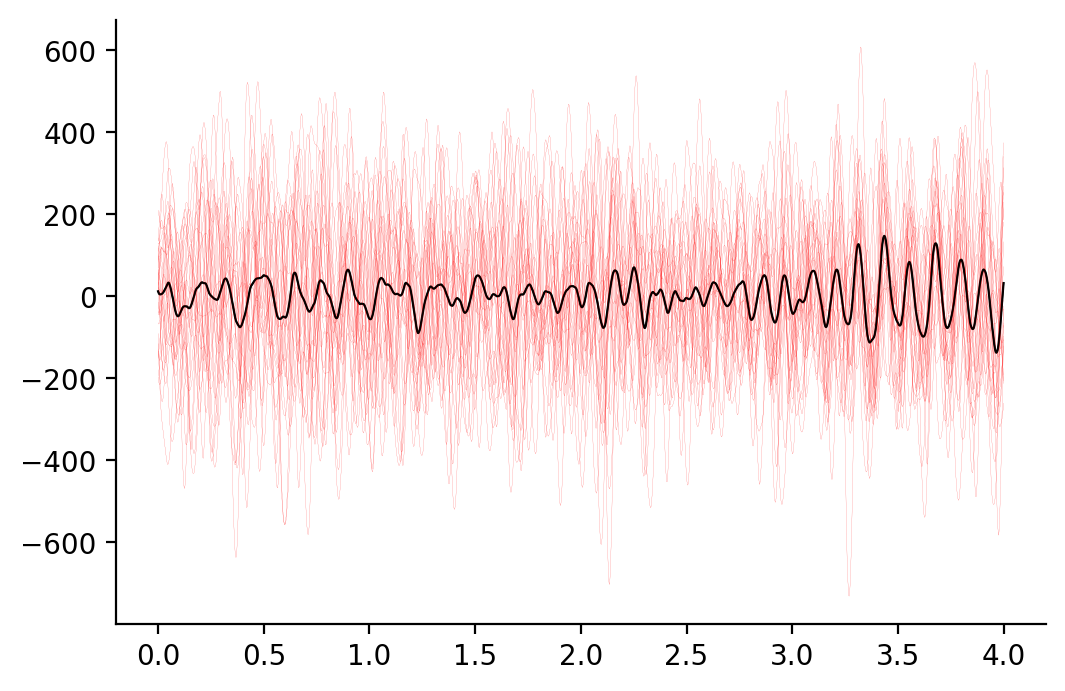

In [37]:

plt.rcParams['figure.dpi'] = 200
x_axis = np.linspace(0, 4, num=X_theta.shape[1])
mean_trial_theta = np.mean(X_theta, axis=0) # Mean LFP across (maximum-likelihood shifted) trials

# Plot the stuff
plt.close()
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(x_axis, mean_trial_theta, linewidth=0.8, color='k')
for i in range(X_theta.shape[0]):
    ax.plot(x_axis, X_theta[i, :], linewidth=0.05, color='r')
ax.plot(x_axis, mean_trial_theta, linewidth=0.5, color='k')

plt.show()

### Visualize combined neuron data

In [ ]:
# Visualization control parameters
start = 0
end = 10
plt.rcParams['figure.dpi'] = 100

# Visualization-specific contstructs
neuron_labels = list(set(pyr_com_neuron_labels))
x_axis = np.linspace(0, 4, num=trial_N)
mean_trial_theta = np.mean(trial_theta_y, axis=0) # Mean LFP across (maximum-likelihood shifted) trials

# Loop over all neuron IDs
for i, neuron in enumerate(neuron_labels[start:end]):

    # Initialize raster data with the trial-combined spike times
    raster_data = [pyr_com_trials[i]]
    color_list = ['r'] # ... which we'll color red
    for j in np.where(np.array(pyr_sep_neuron_labels) == neuron)[0]:
        raster_data.append(pyr_sep_trials[j]) # ... then append the individual trial spike times one-by-one
        color_list.extend(['k']) # ... and color each in black (later we'll color these to indicate those which exhibit phase precession)

    kde_x, kde_y = r_spike_kde([pyr_com_trials[i]], bandwidth, kde_domain_N, kde_domain) # Get the kde for the combined data
    kde_y = kde_y[0] 
    fs = int(trial_N/4) # Lazily ensure sampling frequency is correct
    kde_maxima = find_peaks(kde_y, height=0.2*np.amax(kde_y), distance=0.06*fs)[0] # Get the maxima of the combined data kde (MAGIC NUMBERS)

    print(f'Pyramidal ID: {int(neuron)}')

    # Plot the stuff
    plt.close()
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.patch.set_alpha(0.0)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0].eventplot(raster_data, colors=color_list, lineoffsets=1.6)
    axes[0].set_ylabel('Trial index')
    axes[1].plot(x_axis, kde_y, color='k', linewidth=1.5)
    axes[1].scatter(x_axis[kde_maxima], kde_y[kde_maxima], color='deeppink', s=10, zorder=1)
    axes[1].set_ylabel('Combined data KDE')
    axes[2].plot(x_axis, mean_trial_theta, linewidth=1.5)
    axes[2].scatter(x_axis[kde_maxima], mean_trial_theta[kde_maxima], color='deeppink', s=10, zorder=1)
    axes[2].set_ylabel('Mean LFP')

    plt.show()

### Visualize individual trials for each neuron

In [ ]:
# a posteriori label confirmation
plt.rcParams['figure.dpi'] = 200

# Visualization control parameters  
confirm_supervisor = True
neuron_of_interest = 37

# Visualization specific constructs 
time_axis = np.linspace(0, 4, num=X_kde.shape[1])

for trial_row in np.where(np.array(pyr_sep_neuron_labels) == neuron_of_interest)[0]:  #range(X_kde.shape[0]):

    # Use PRQ algorithm to get cycle central tendencies
    prq, CT_times = compute_PRQ(
        time_axis,
        X_theta[trial_row, :],
        pyr_sep_trials[trial_row],
        fs
    )

    # Determine printoff label from labels
    string_label = 'Null'
    if Y[trial_row, 0] == 1:
        string_label = 'Precession'

    # Printoff neuron information
    print(f'Neuron: {pyr_sep_neuron_labels[trial_row]}, Label: {string_label}')
    print(f'Trial: {pyr_sep_trial_labels[trial_row]}')

    
    fig, axes = plt.subplots(2, 1)
    fig.patch.set_alpha(0.0)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    peak_indices = find_peaks(X_kde[trial_row, :], height=0.05*np.amax(X_kde[trial_row, :]), distance=0.06*fs)[0]
    theta_oscillation = X_theta[trial_row, :]
    kde = X_kde[trial_row, :]
    axes[0].plot(time_axis, kde, linewidth=1.5, color='k')
    axes[0].scatter(time_axis[peak_indices], kde[peak_indices], s=10, color='b')
    axes[0].eventplot(pyr_sep_trials[trial_row], color='deeppink', lineoffsets=1.6)
    axes[1].plot(time_axis, theta_oscillation, linewidth=1.5)
    axes[1].scatter(time_axis[peak_indices], theta_oscillation[peak_indices], s=10, color='b')
    axes[1].scatter(time_axis[np.array([int(x*fs) for x in CT_times])], theta_oscillation[np.array([int(x*fs) for x in CT_times])], s=10, color='r')

    plt.show()


### Visualize manual labelling

Pyramidal ID: 1


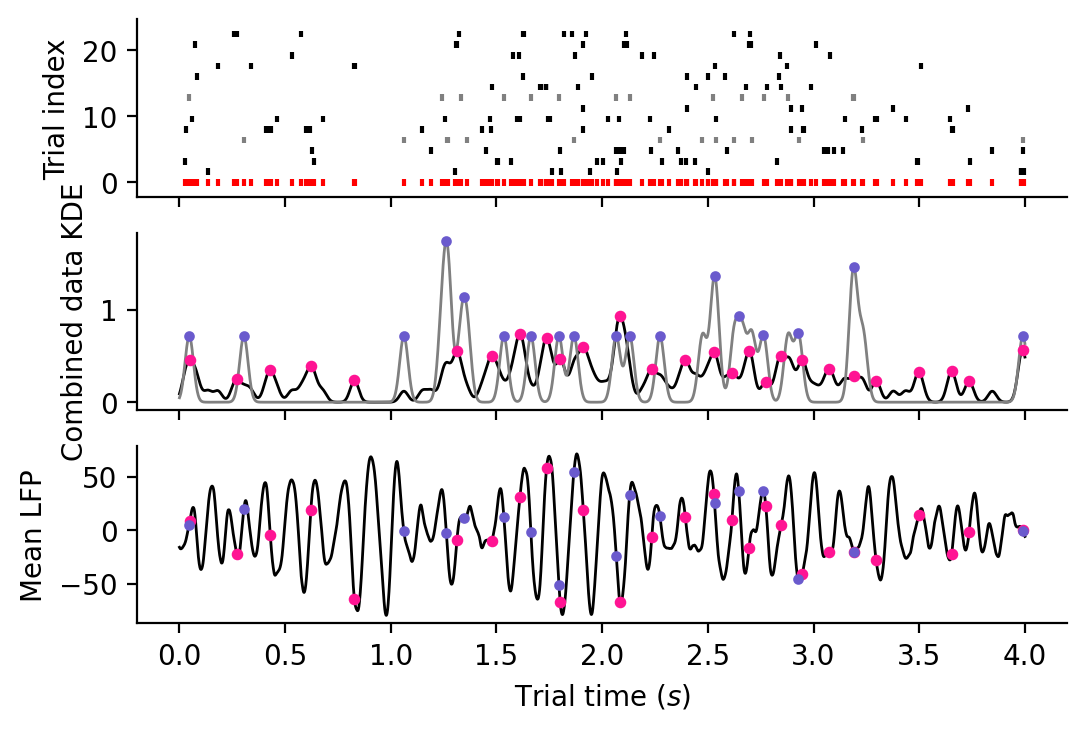

Pyramidal ID: 2


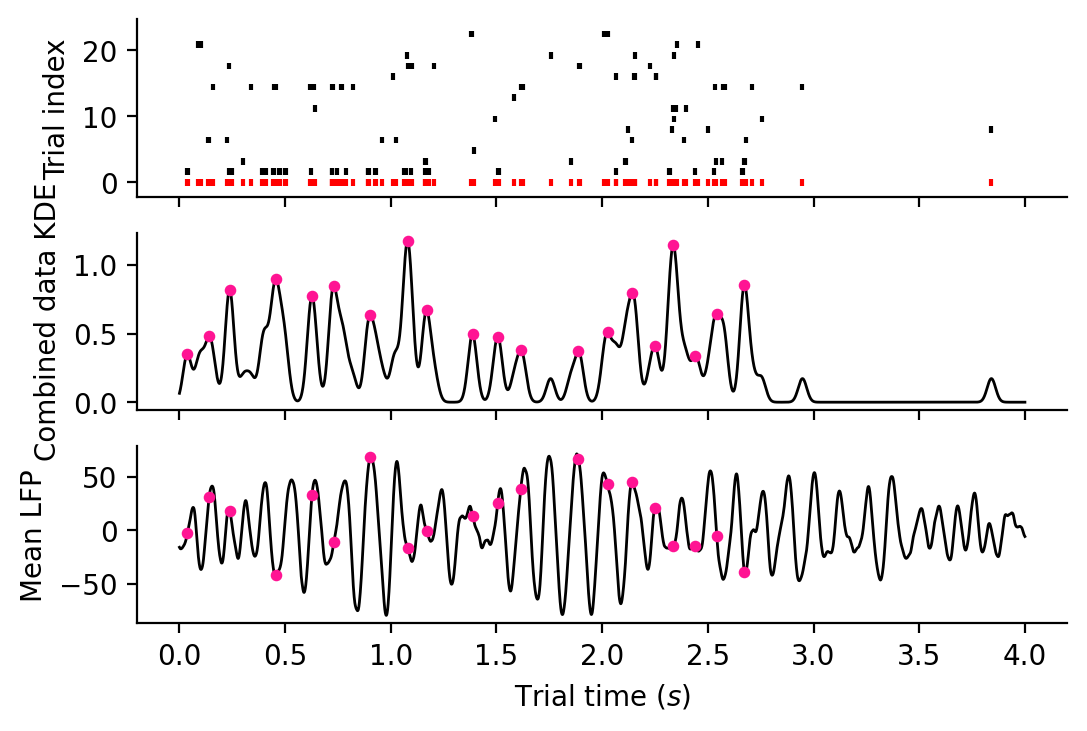

Pyramidal ID: 3


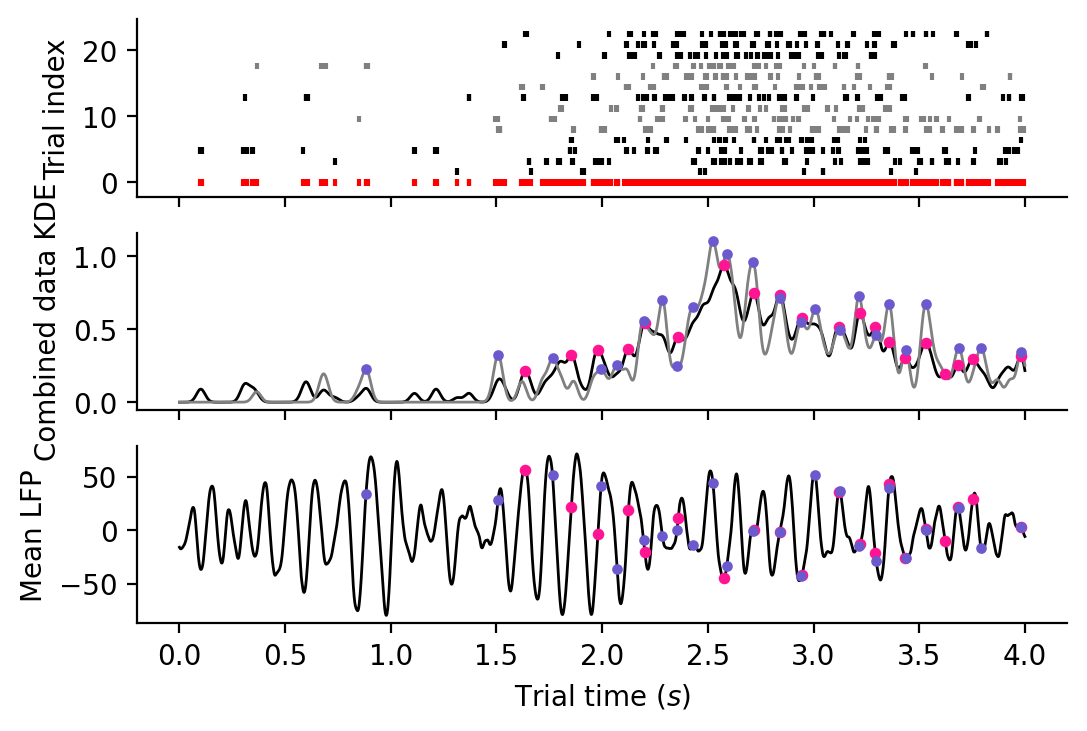

Pyramidal ID: 4


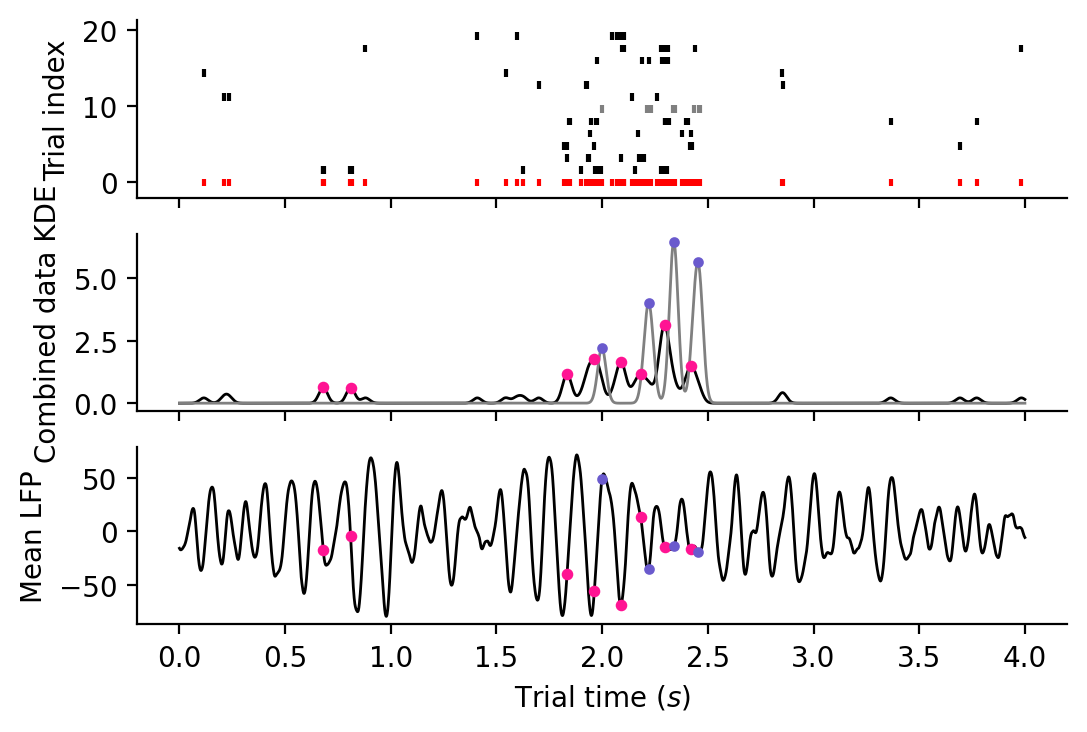

Pyramidal ID: 5


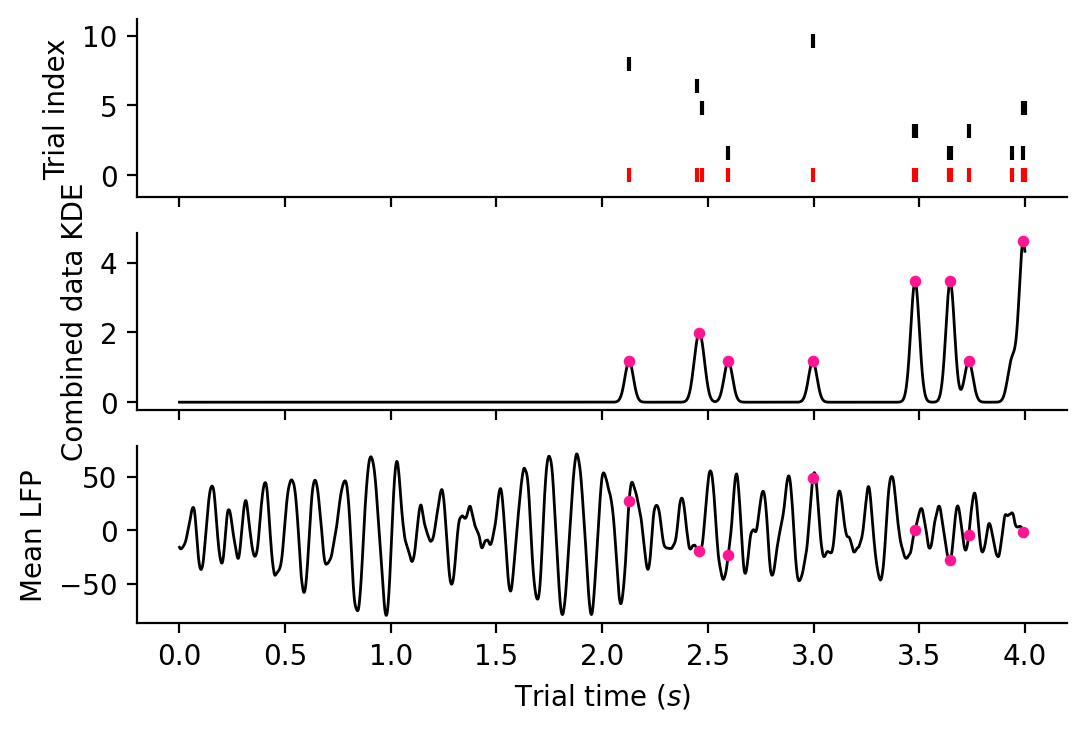

Pyramidal ID: 6


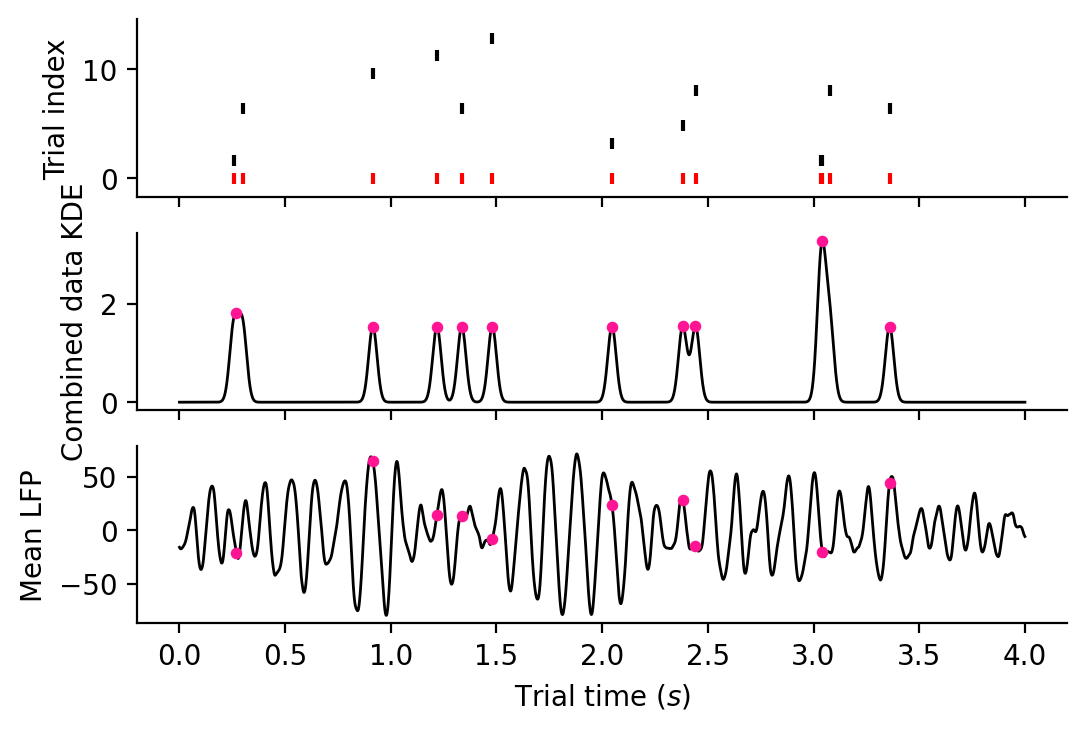

Pyramidal ID: 7


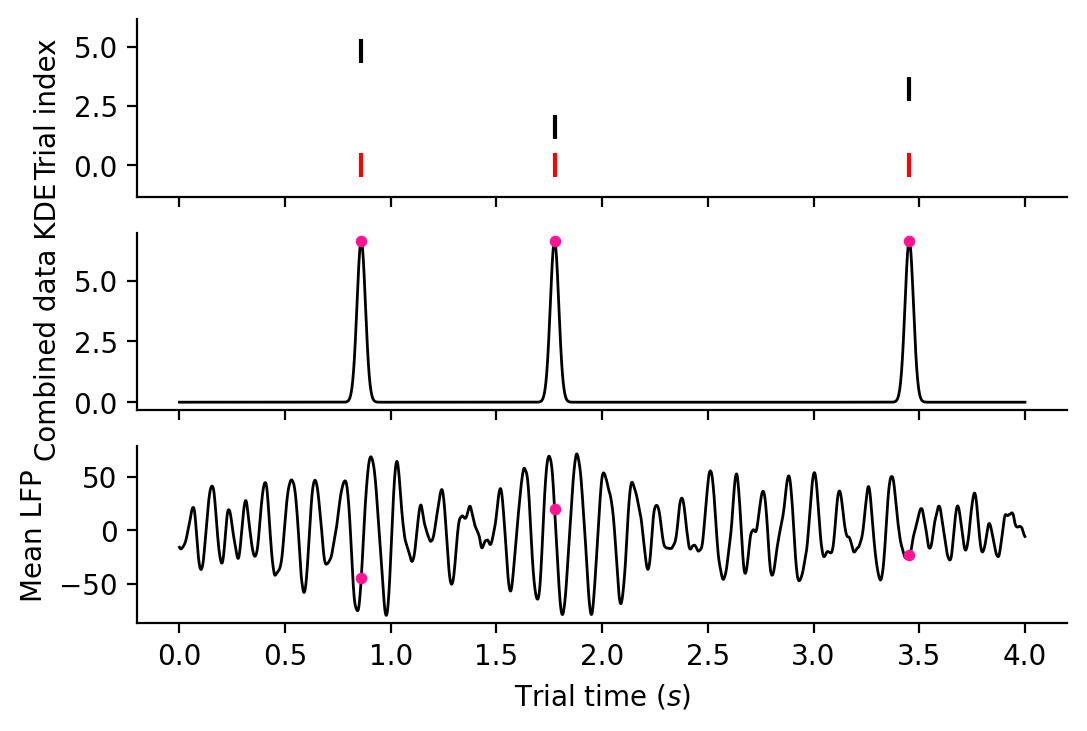

Pyramidal ID: 8


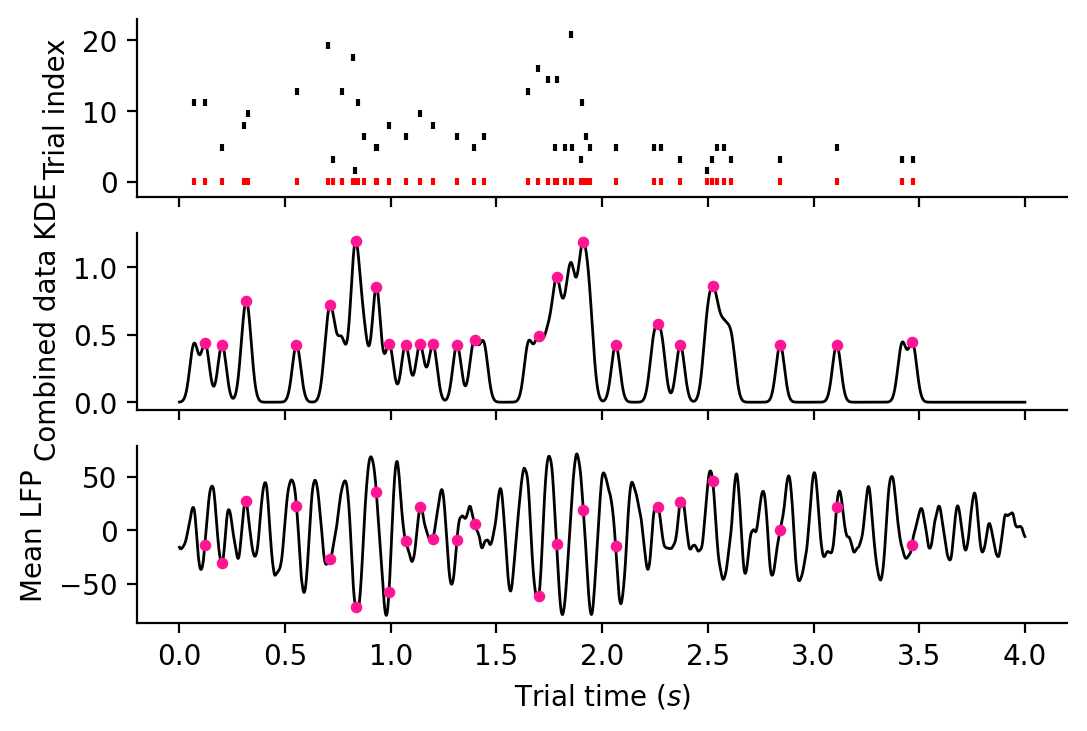

Pyramidal ID: 9


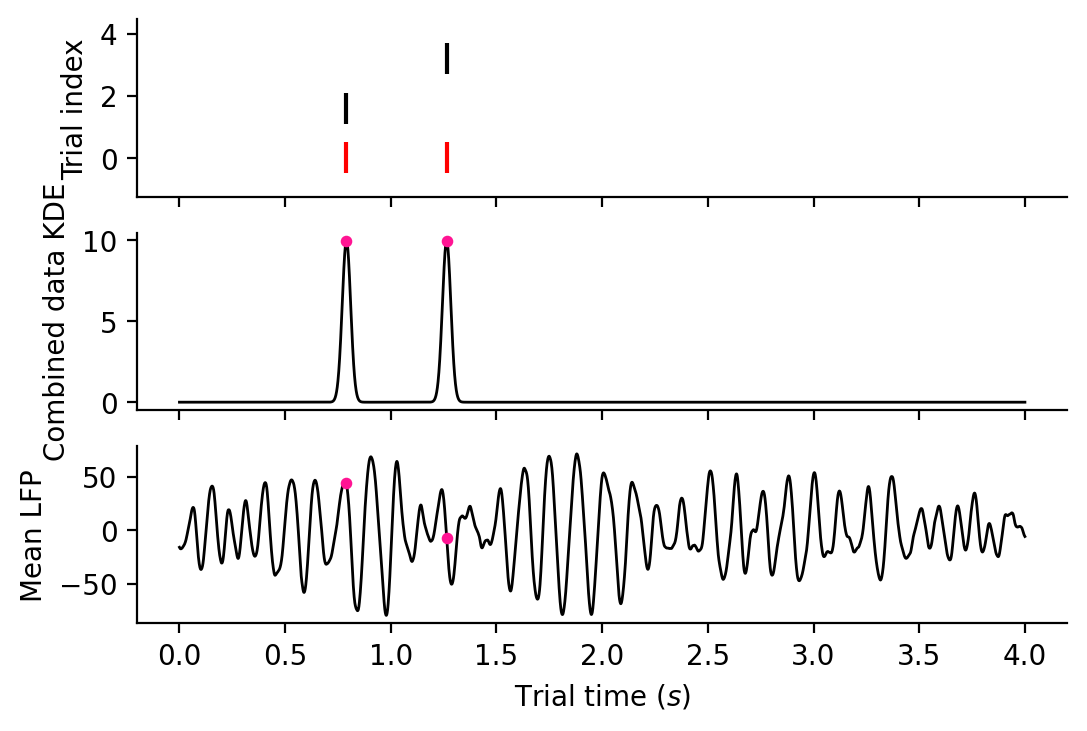

Pyramidal ID: 10


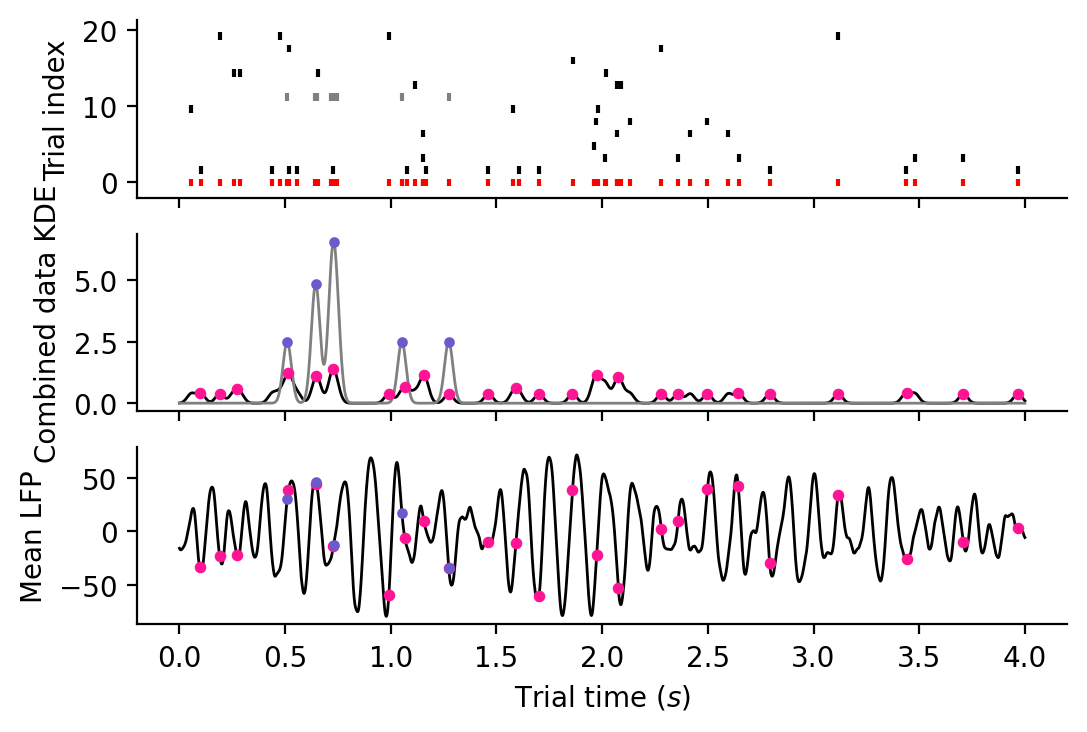

Pyramidal ID: 11


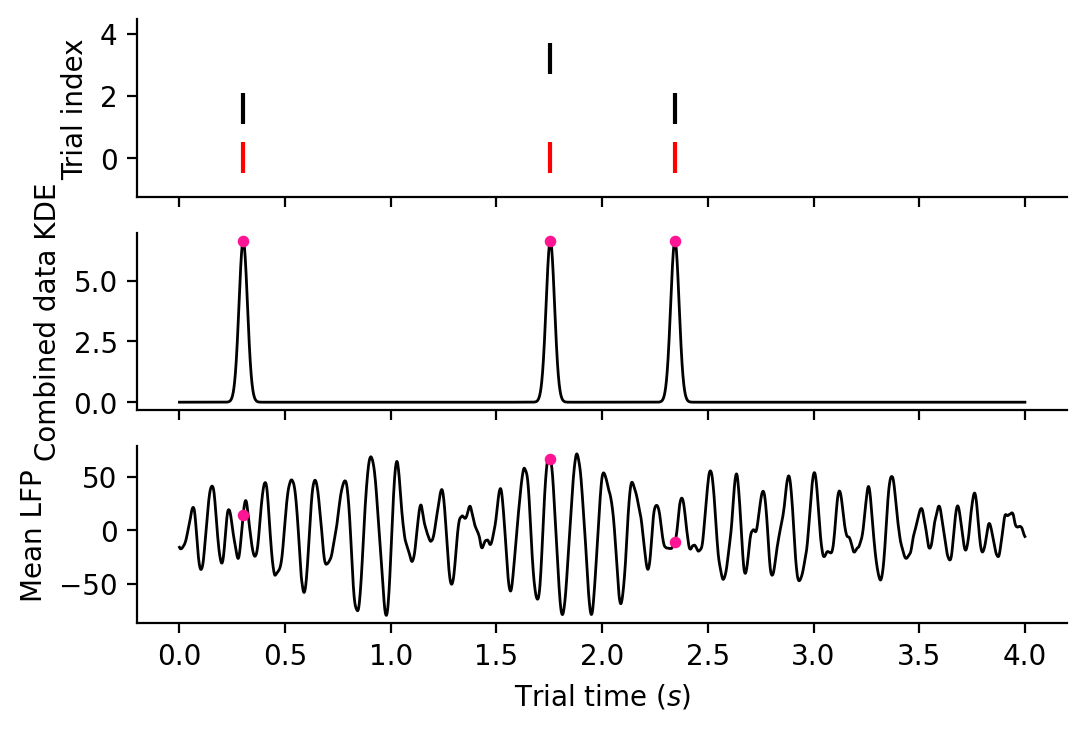

Pyramidal ID: 12


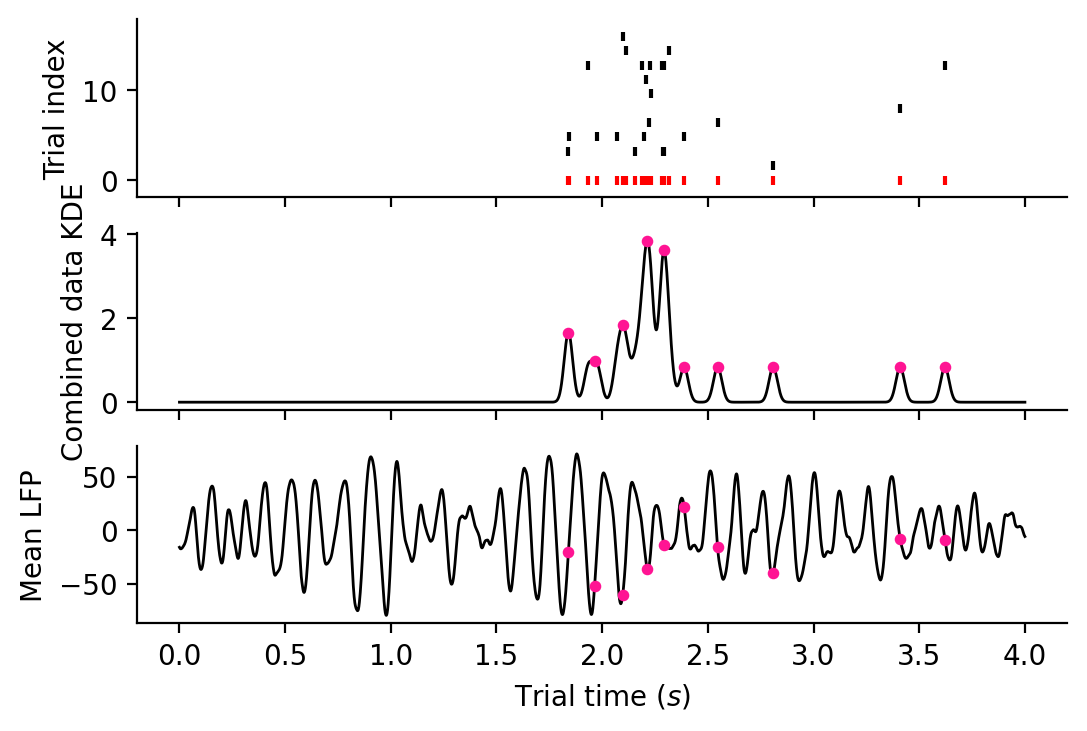

Pyramidal ID: 13


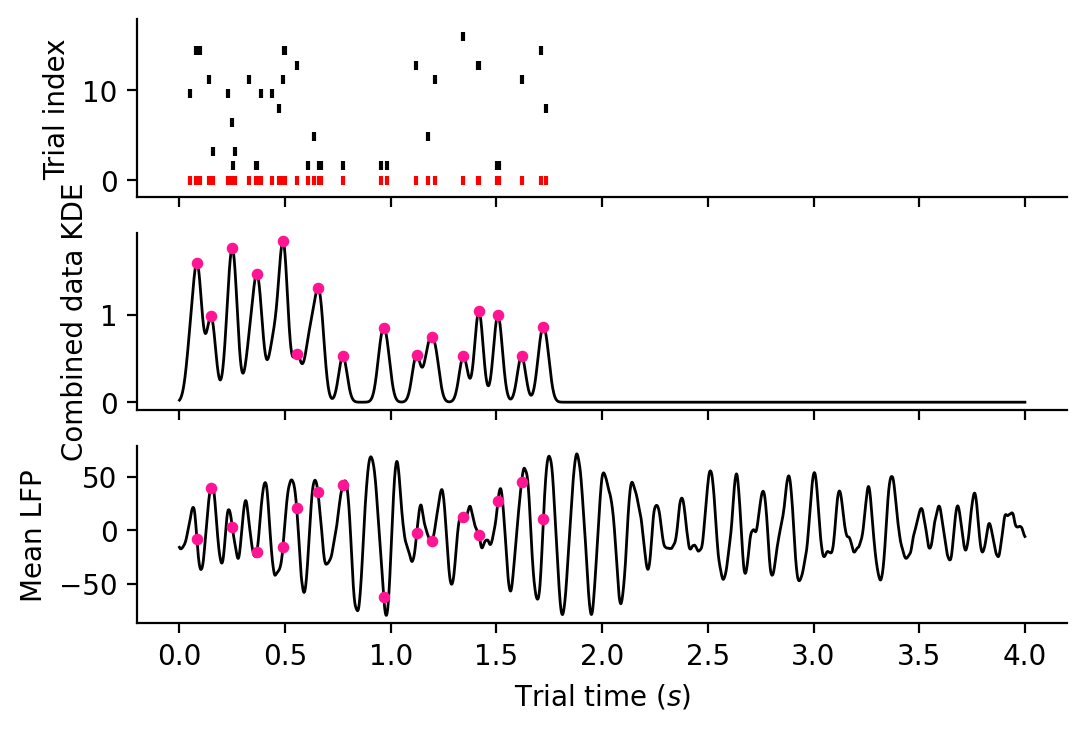

Pyramidal ID: 14


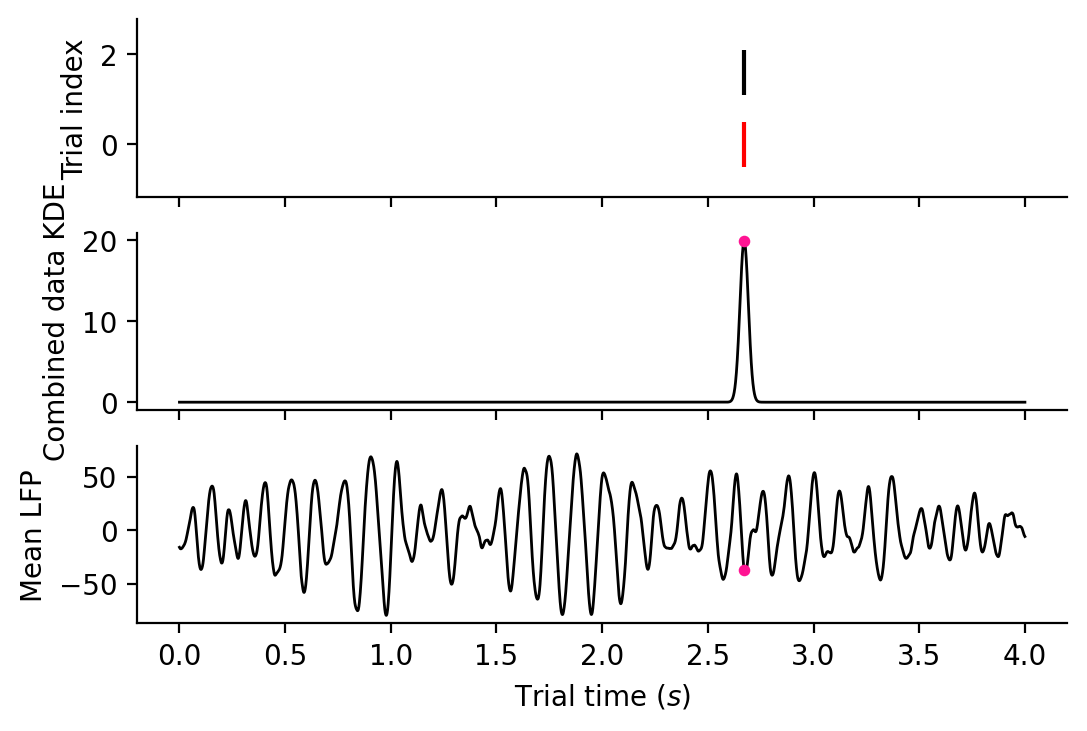

Pyramidal ID: 15


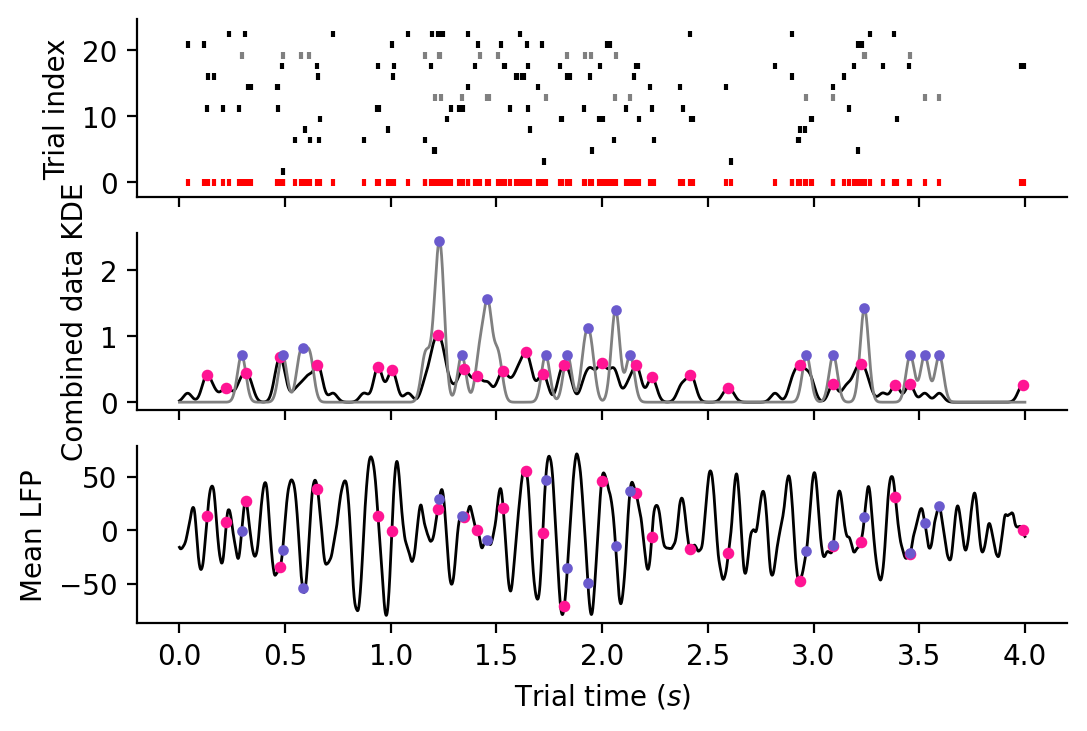

Pyramidal ID: 16


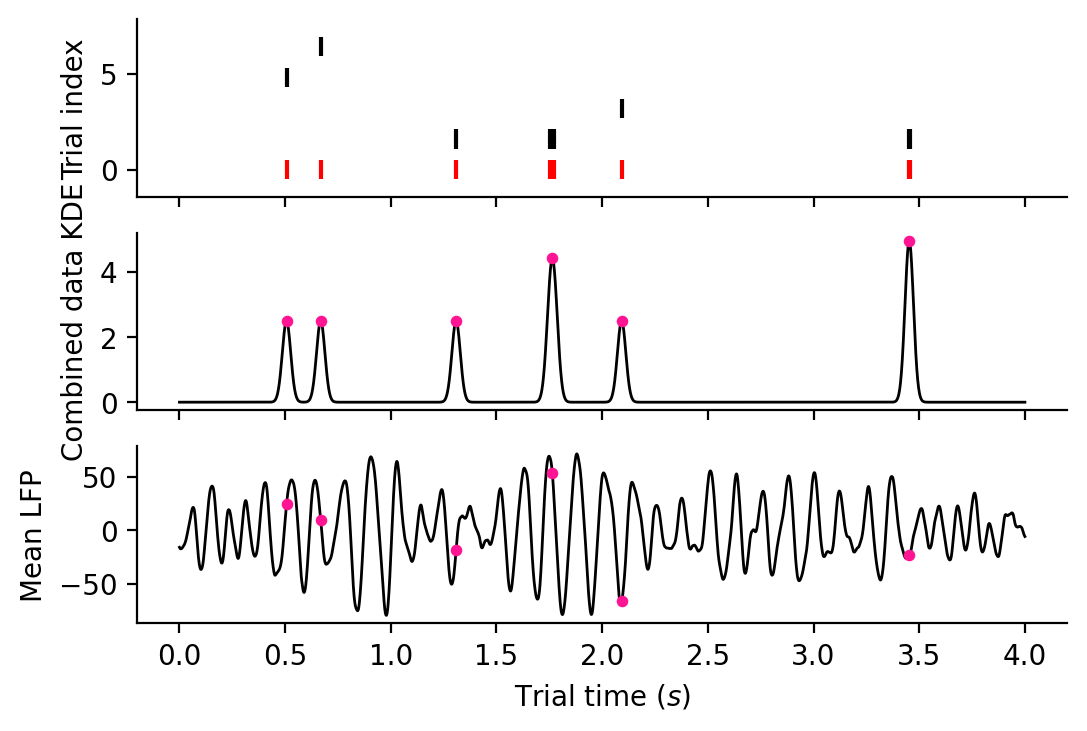

Pyramidal ID: 17


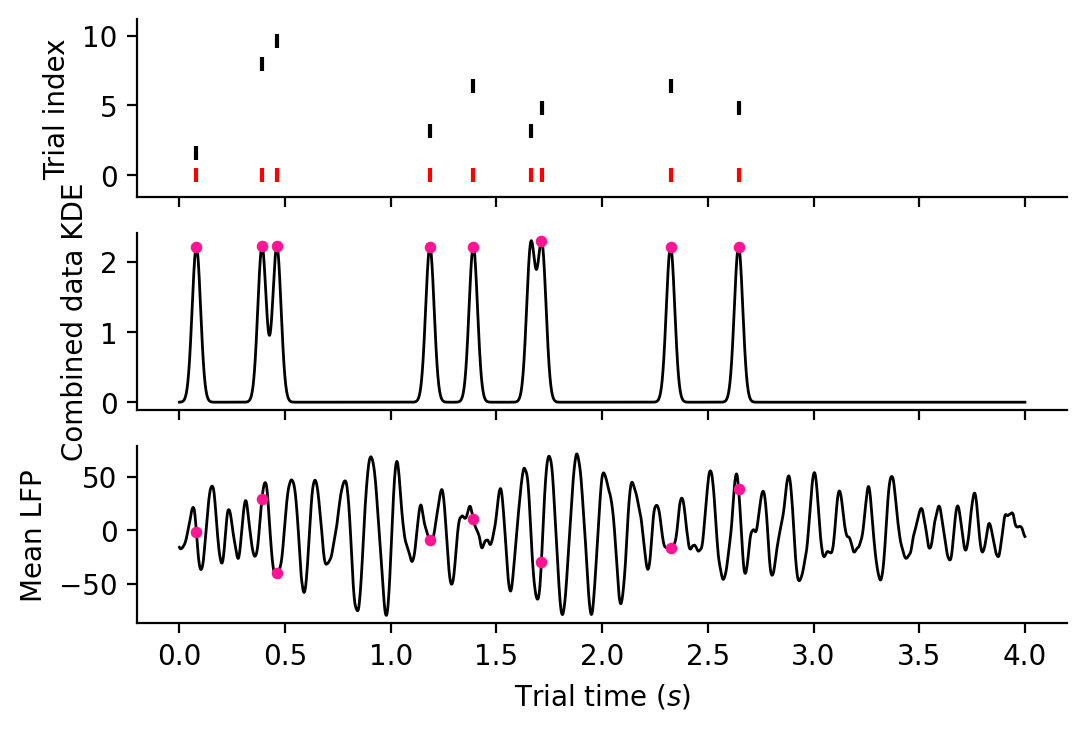

Pyramidal ID: 18


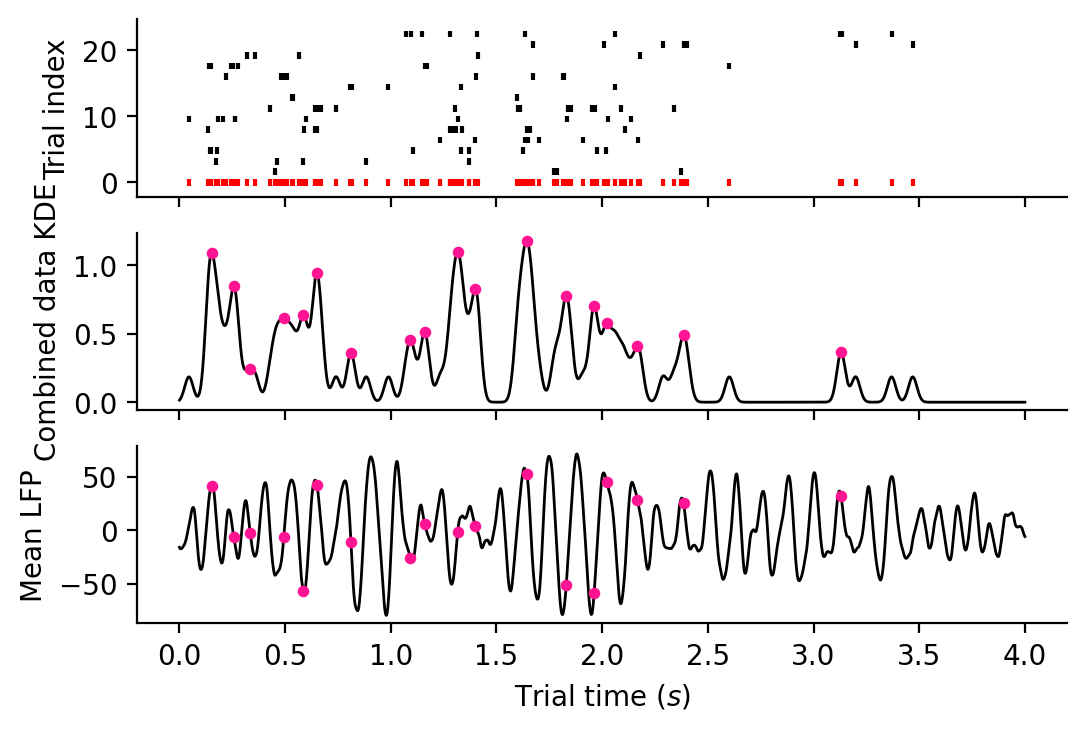

Pyramidal ID: 19


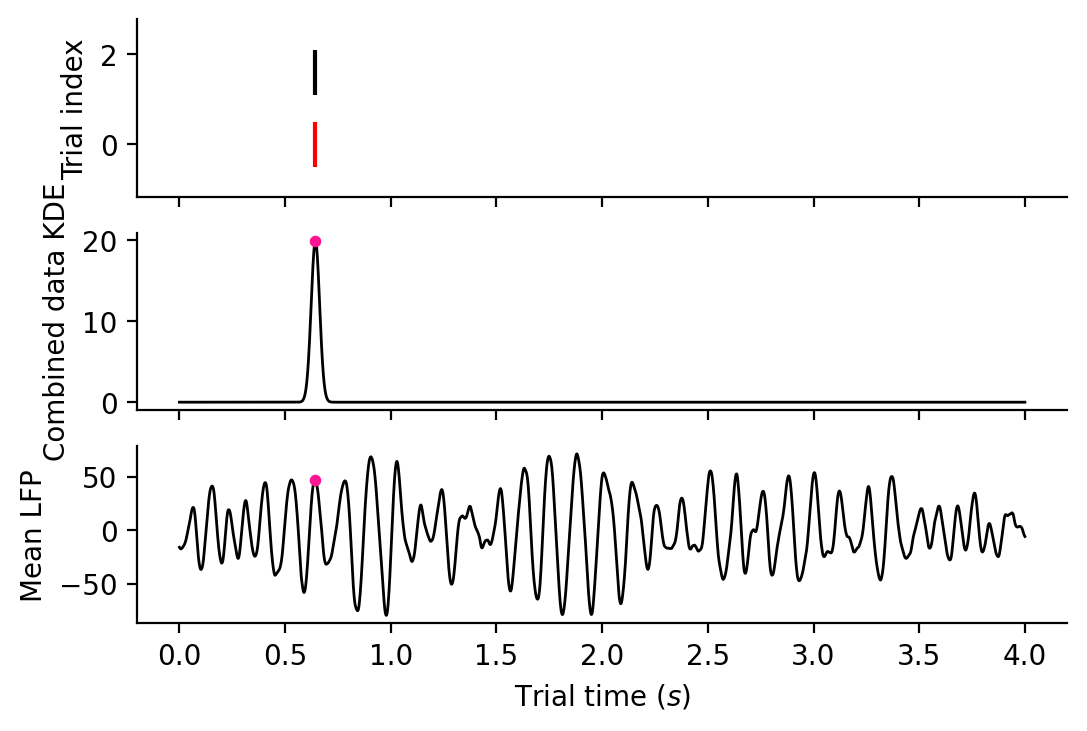

Pyramidal ID: 21


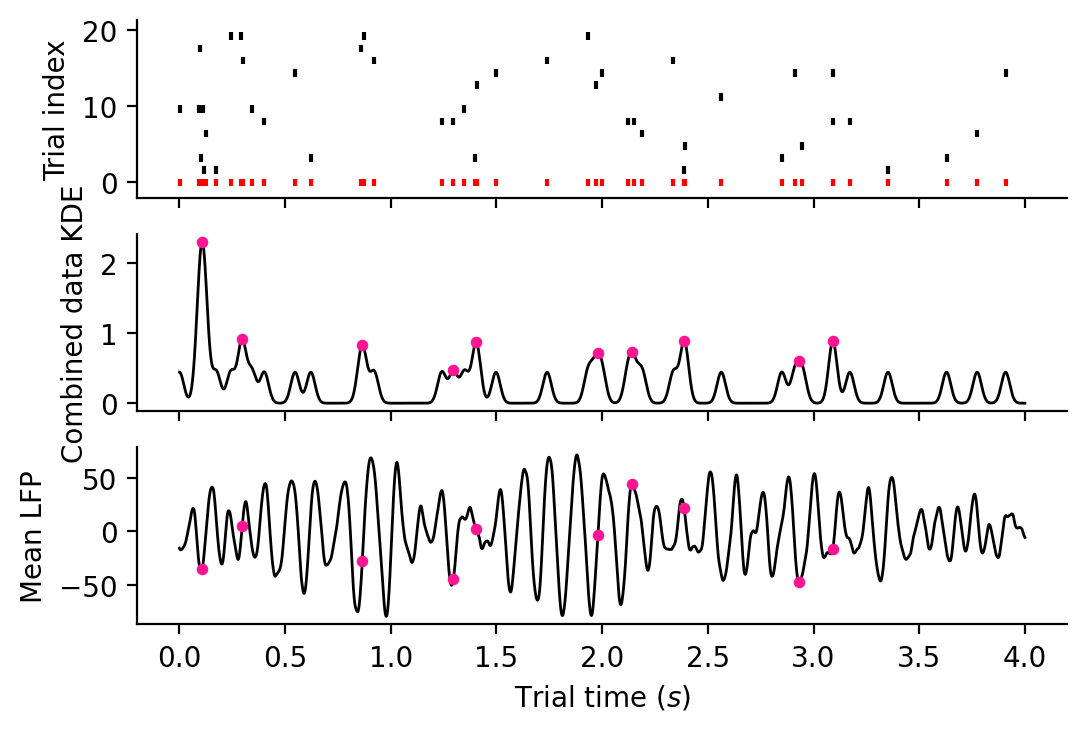

Pyramidal ID: 22


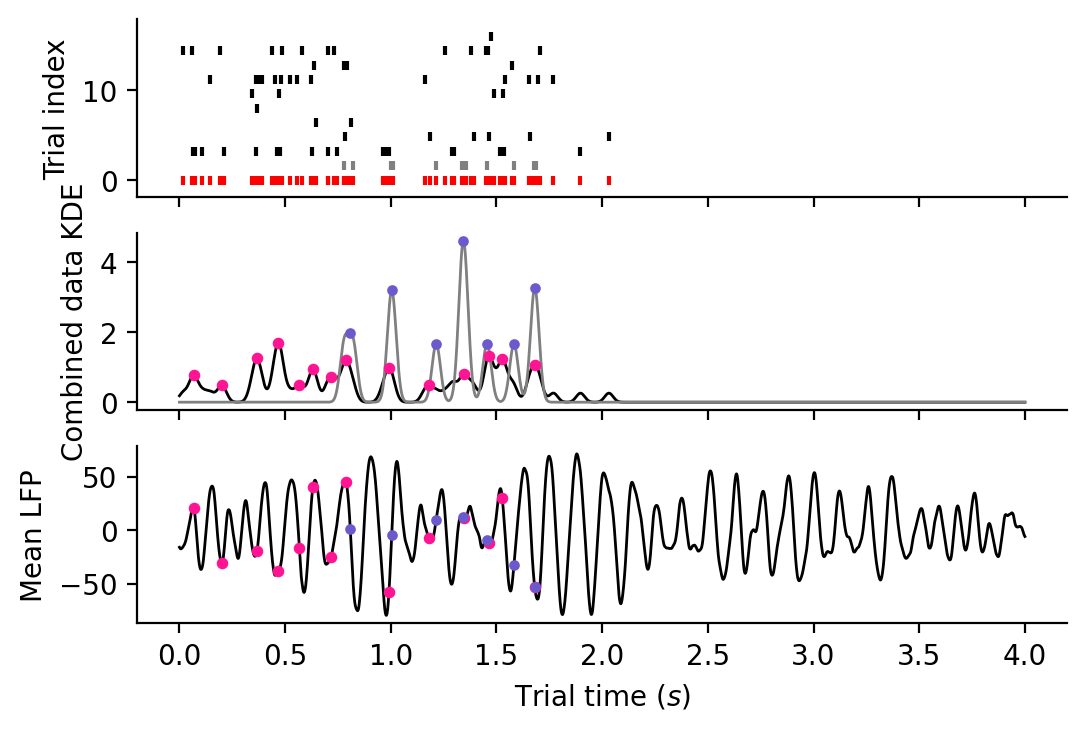

Pyramidal ID: 24


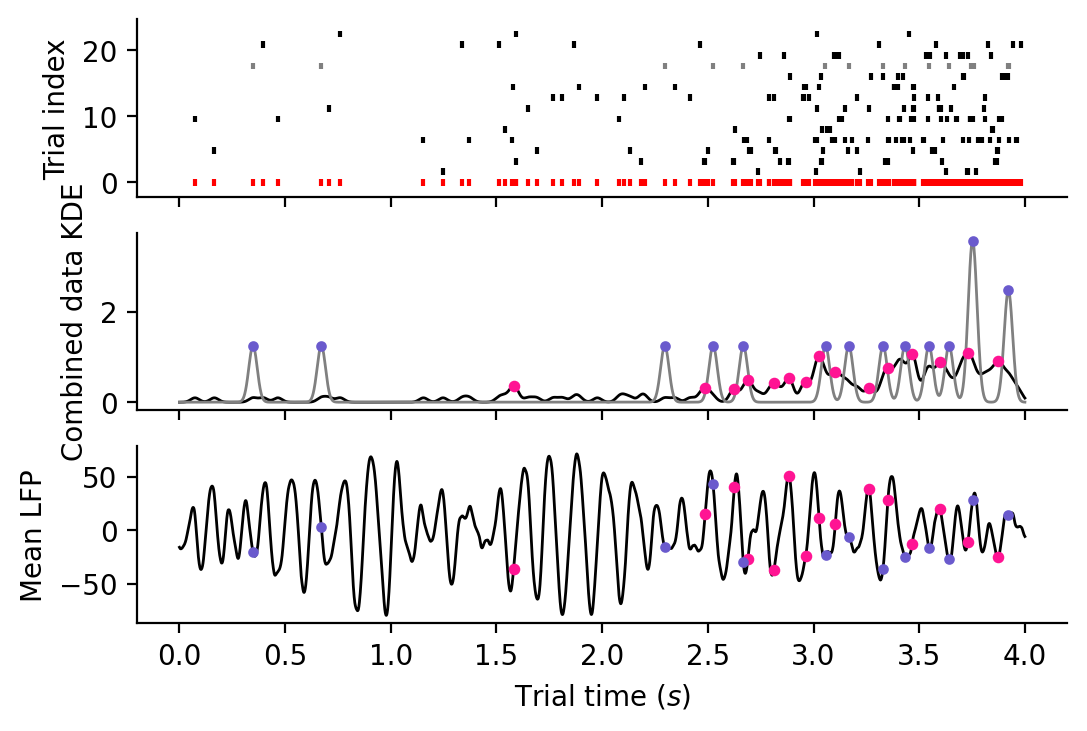

Pyramidal ID: 25


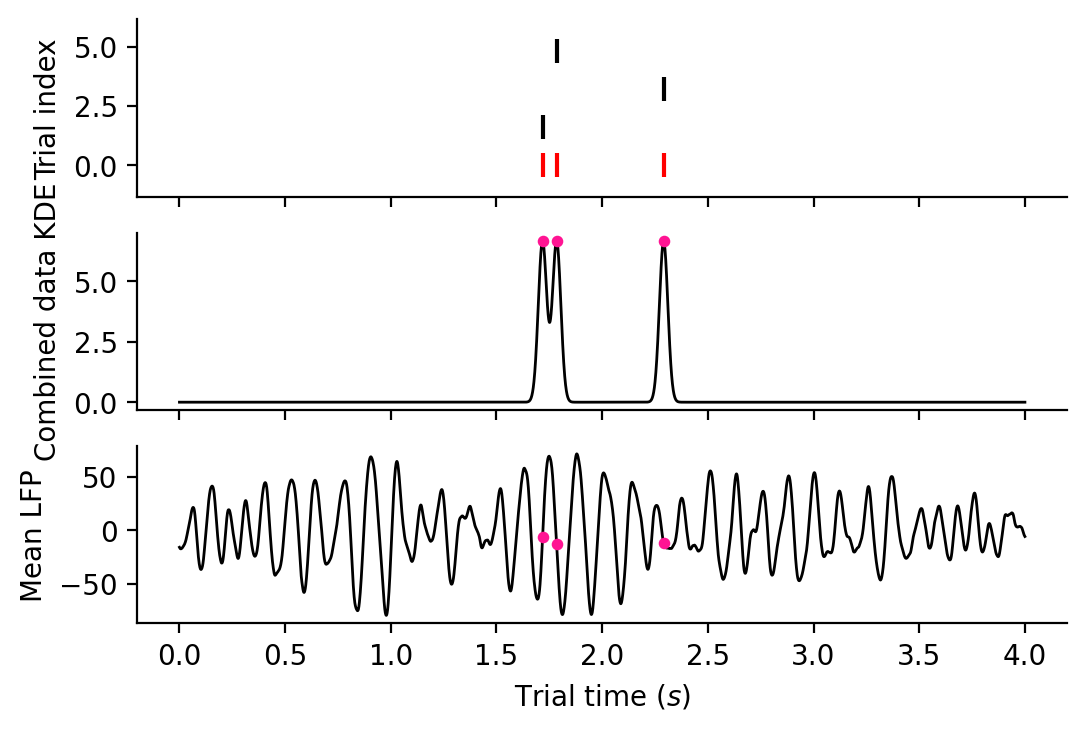

Pyramidal ID: 26


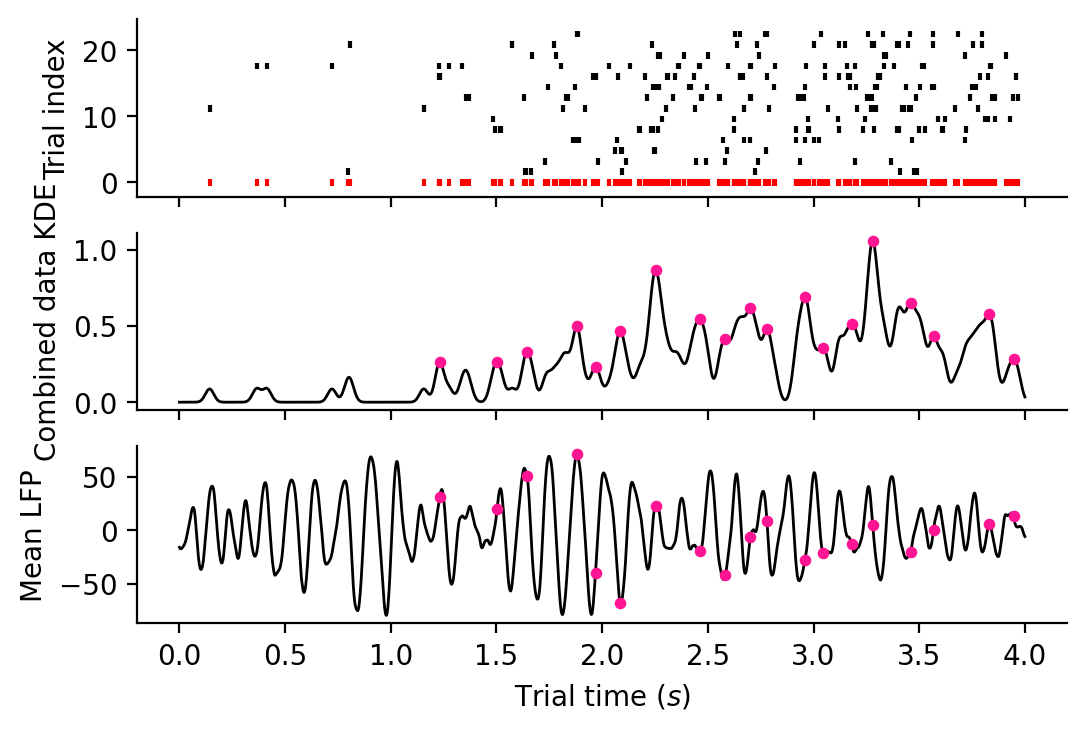

Pyramidal ID: 27


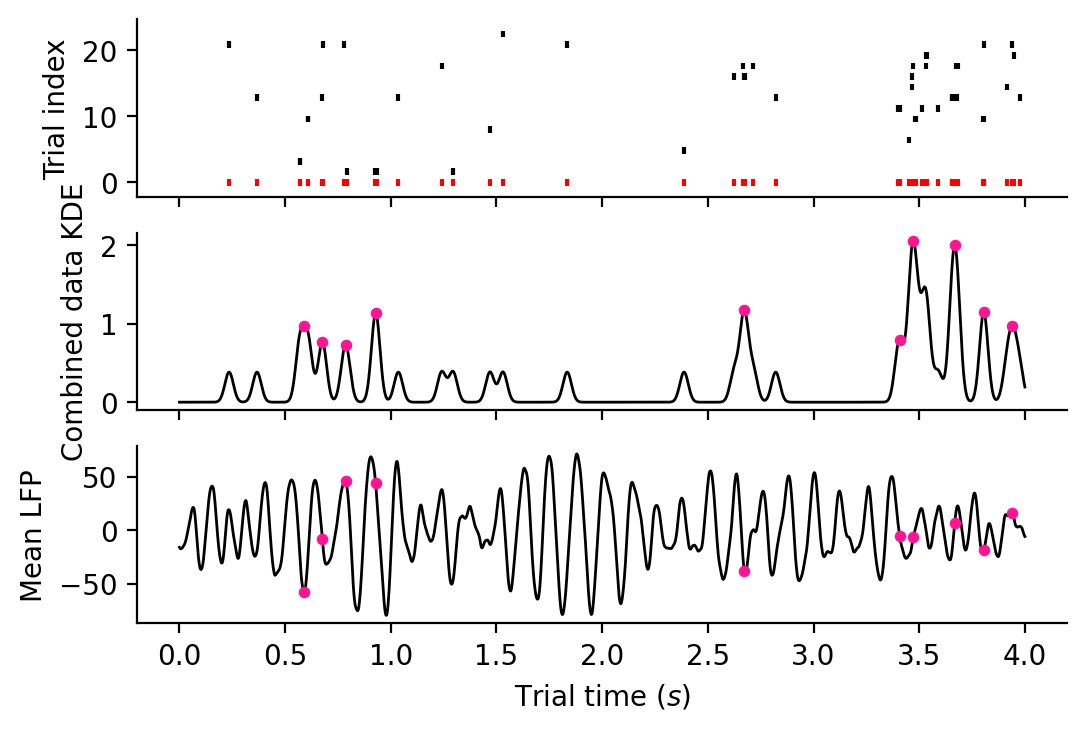

Pyramidal ID: 28


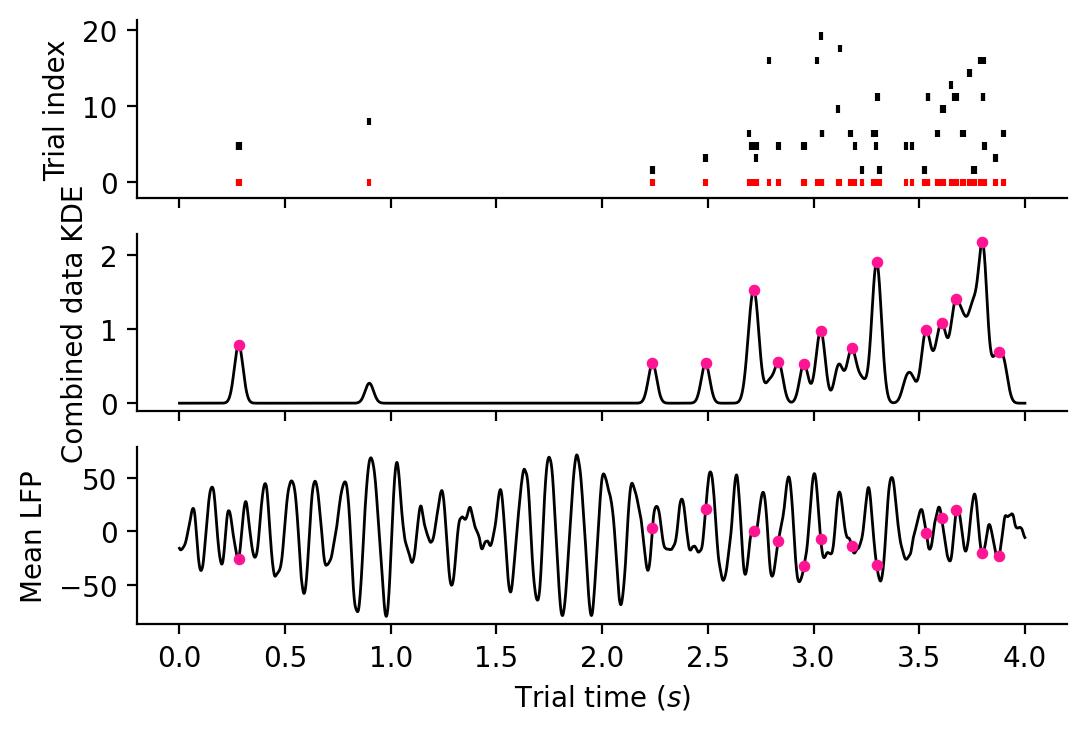

Pyramidal ID: 30


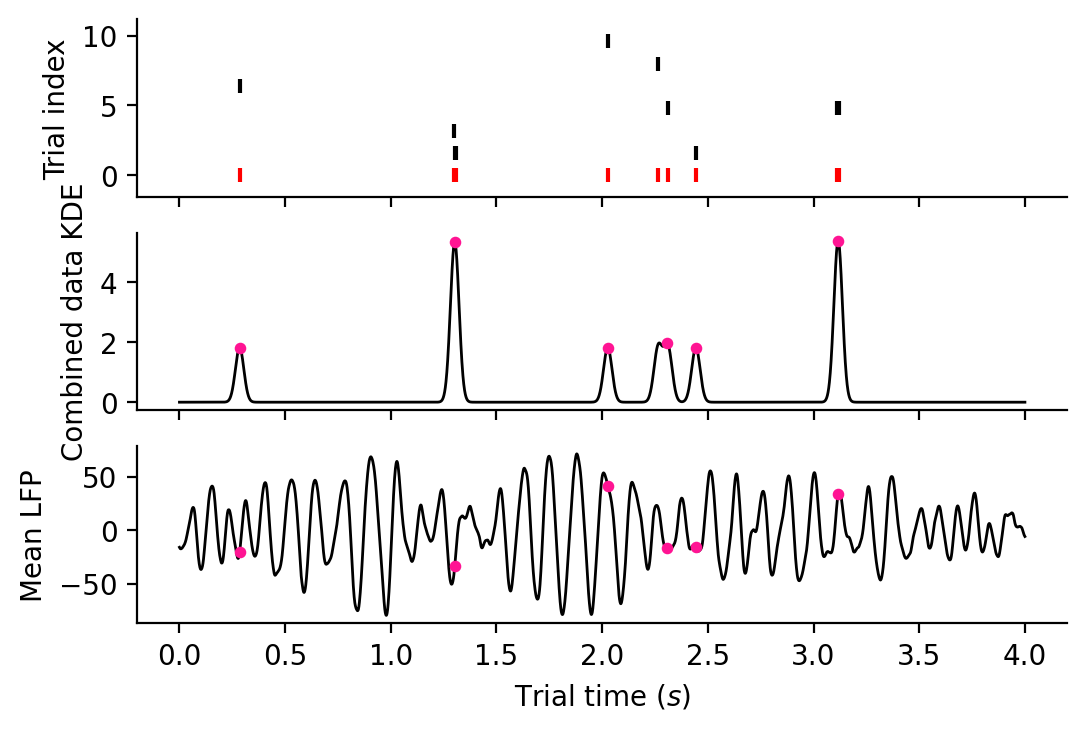

Pyramidal ID: 31


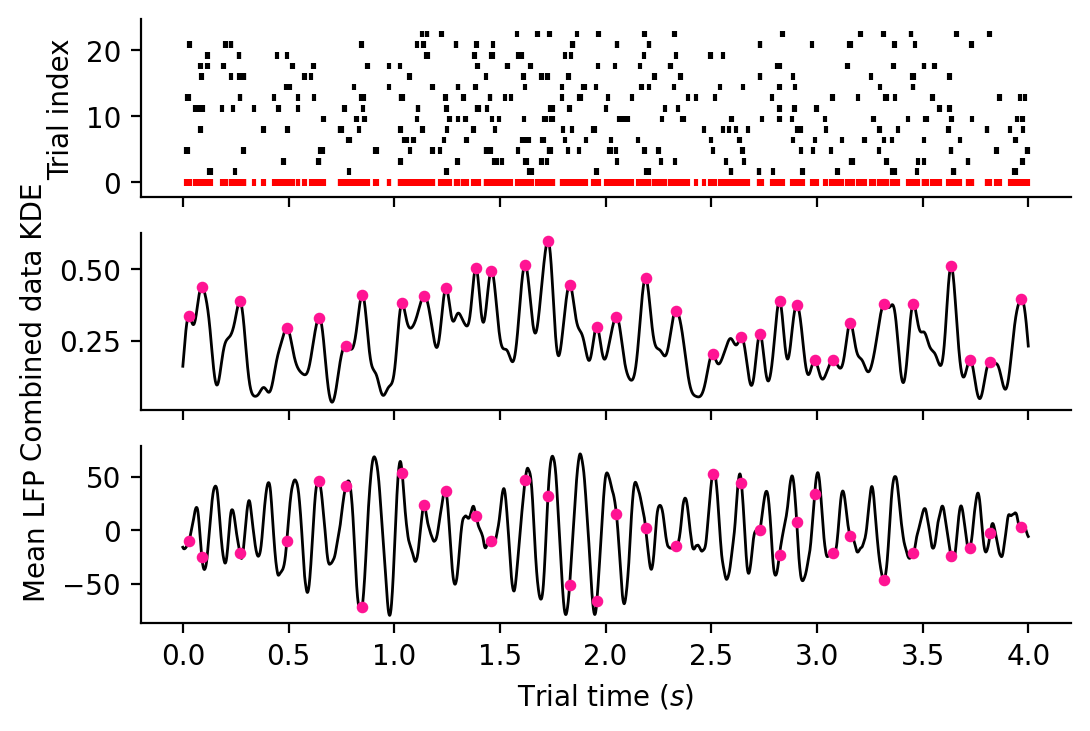

Pyramidal ID: 32


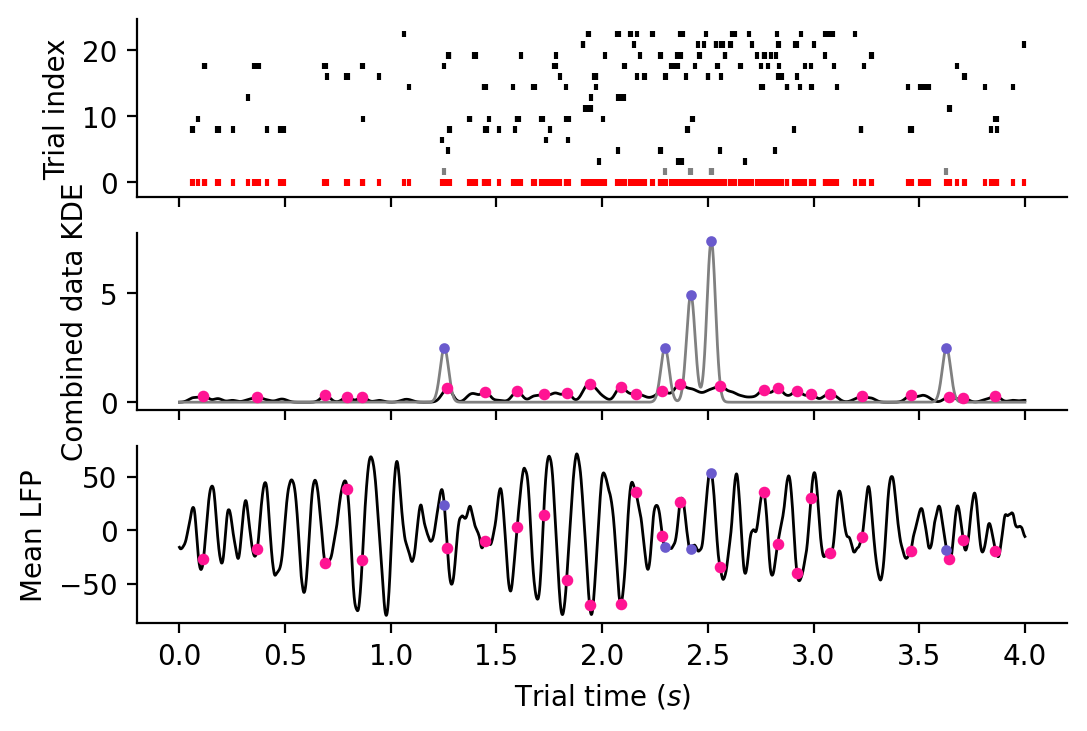

Pyramidal ID: 33


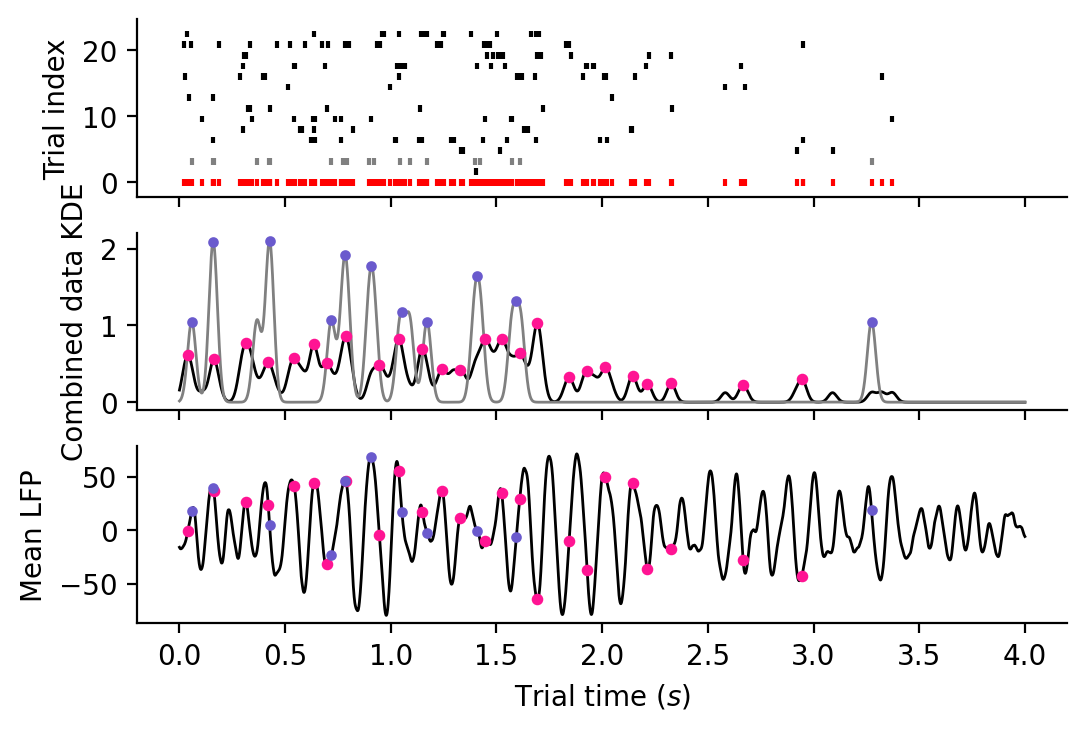

Pyramidal ID: 34


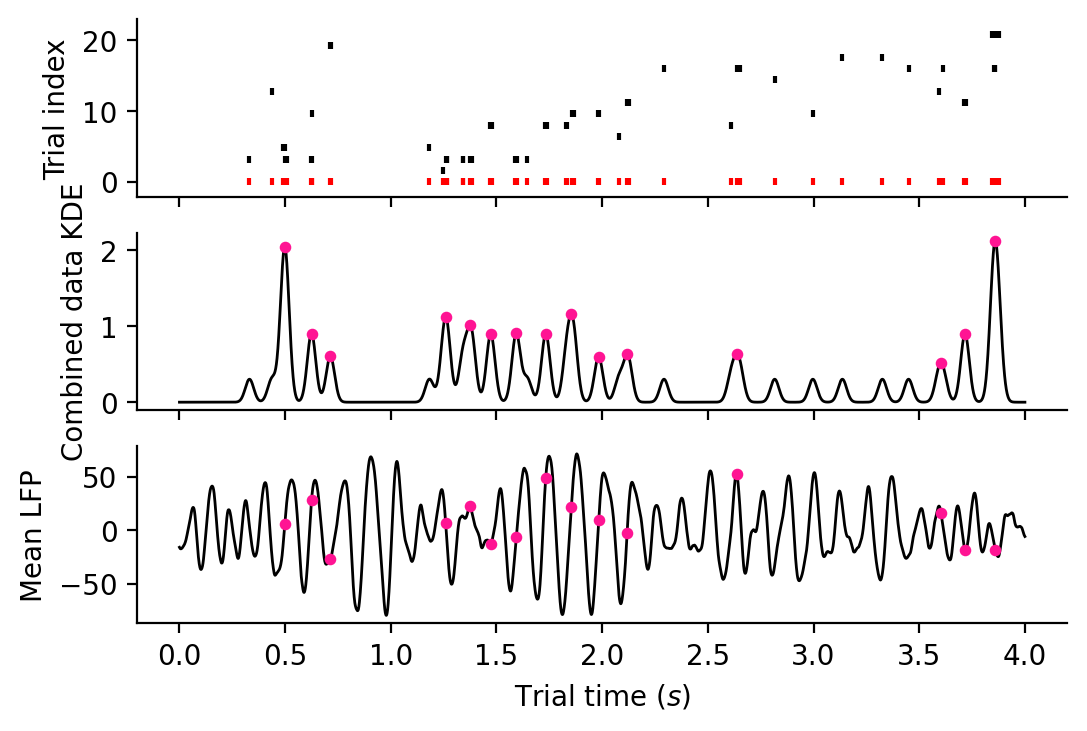

Pyramidal ID: 35


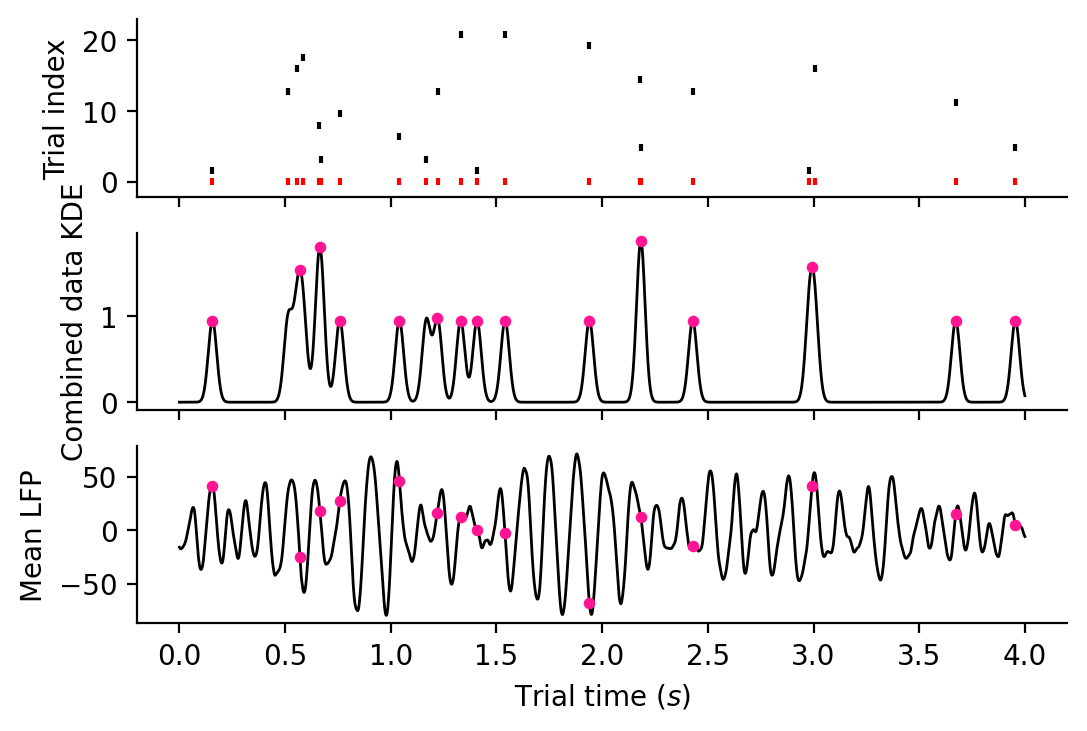

Pyramidal ID: 36


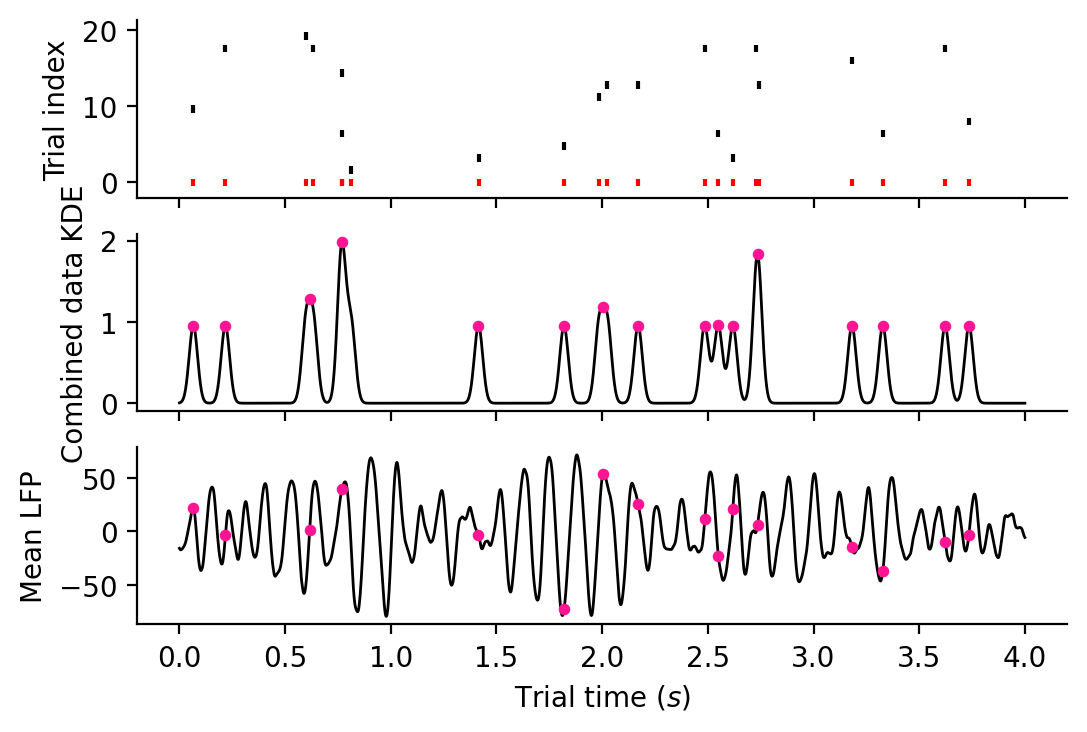

Pyramidal ID: 37


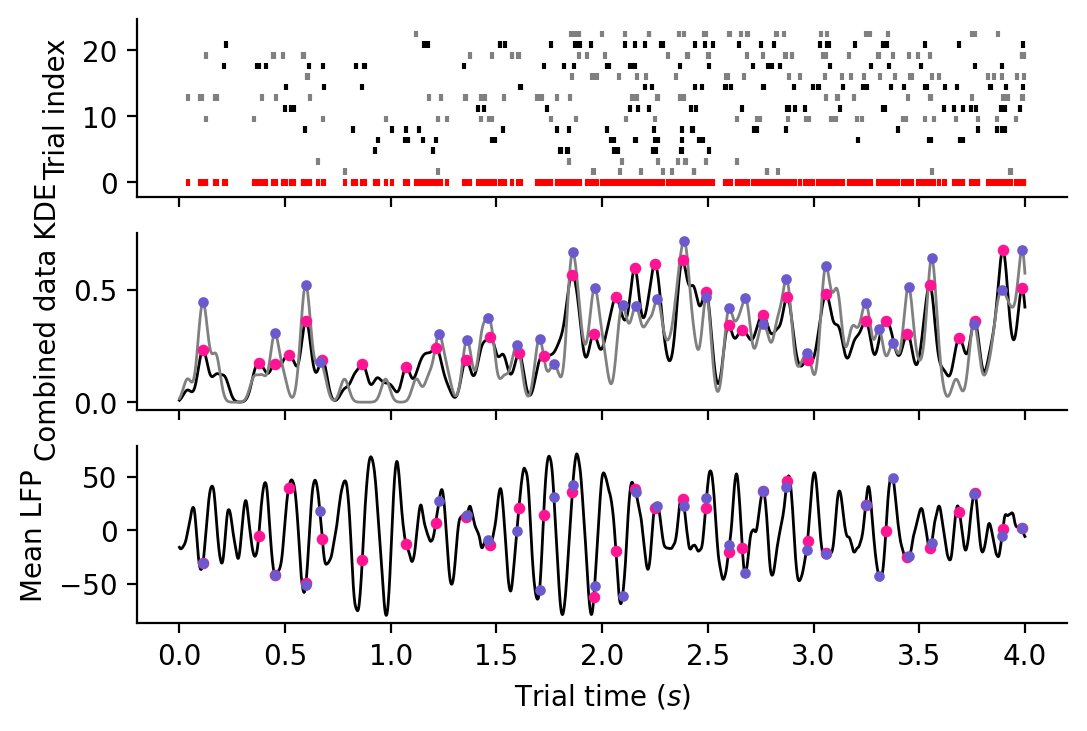

Pyramidal ID: 38


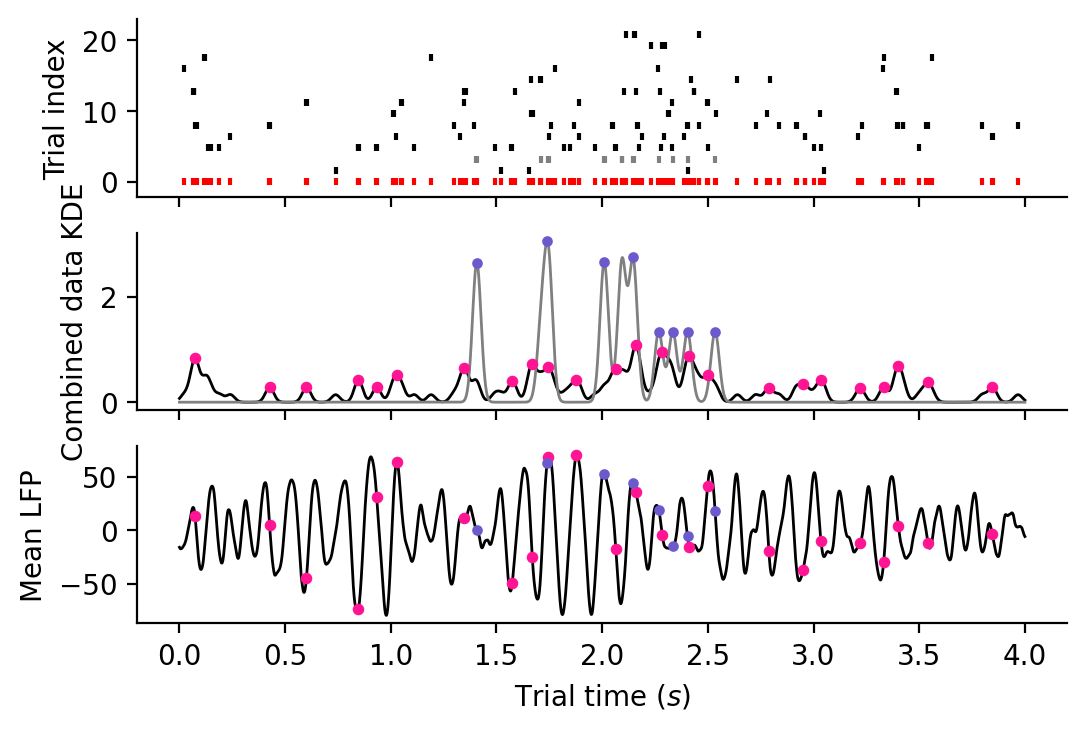

Pyramidal ID: 39


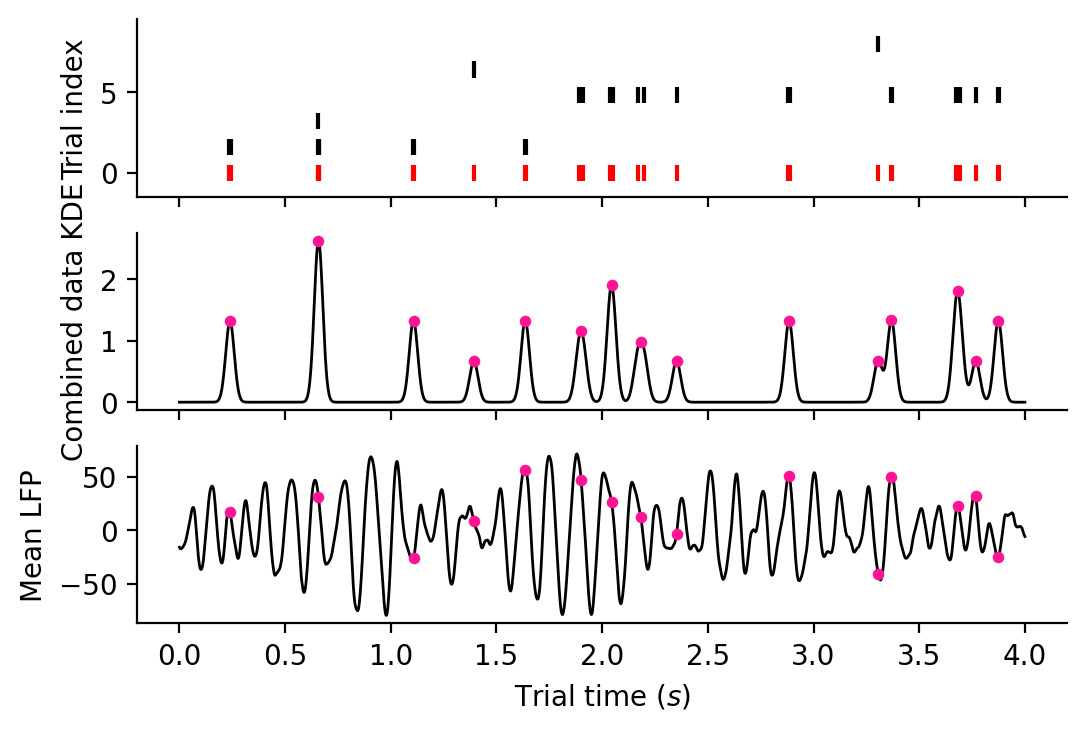

Pyramidal ID: 40


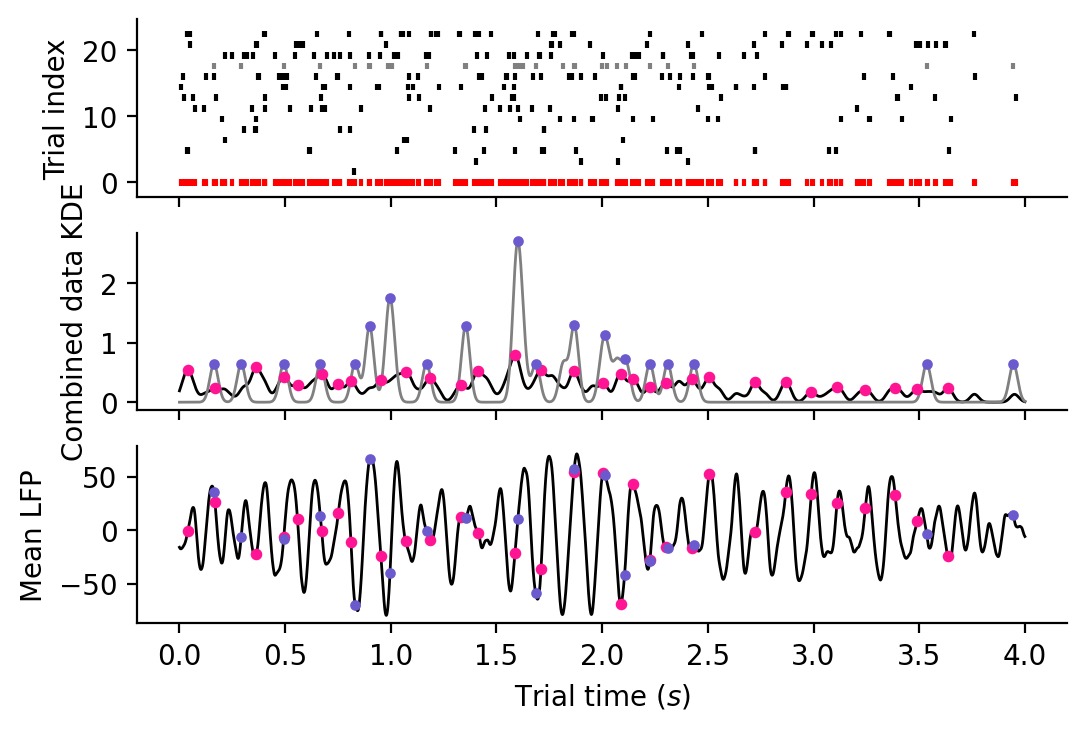

Pyramidal ID: 41


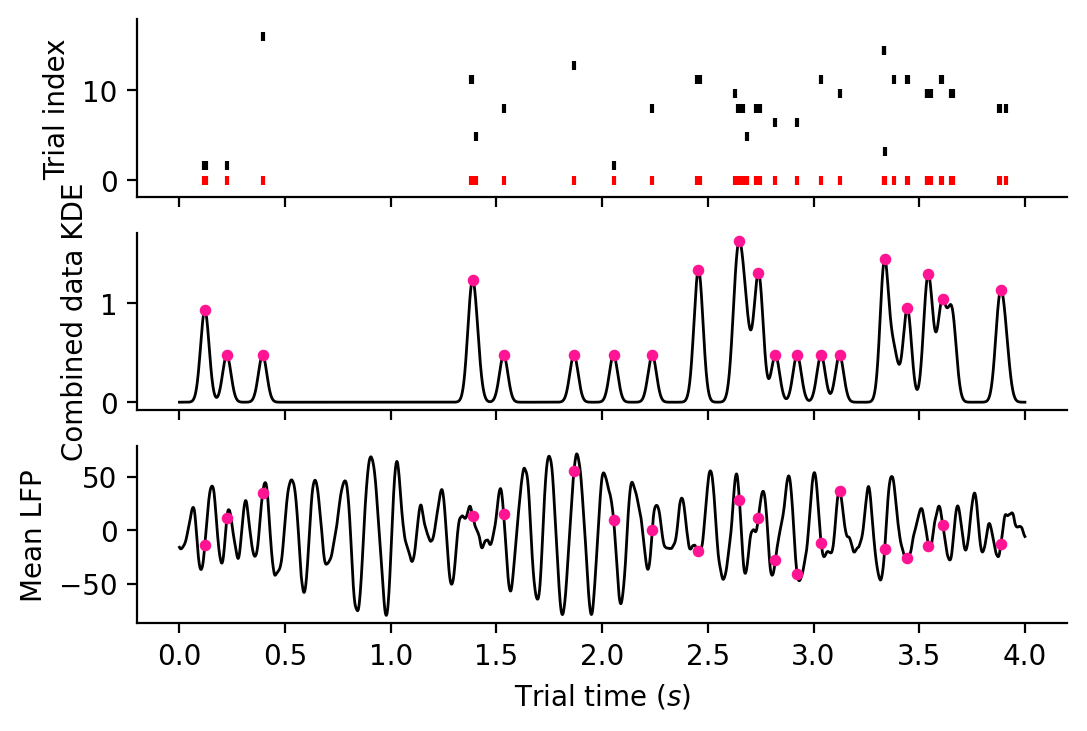

Pyramidal ID: 42


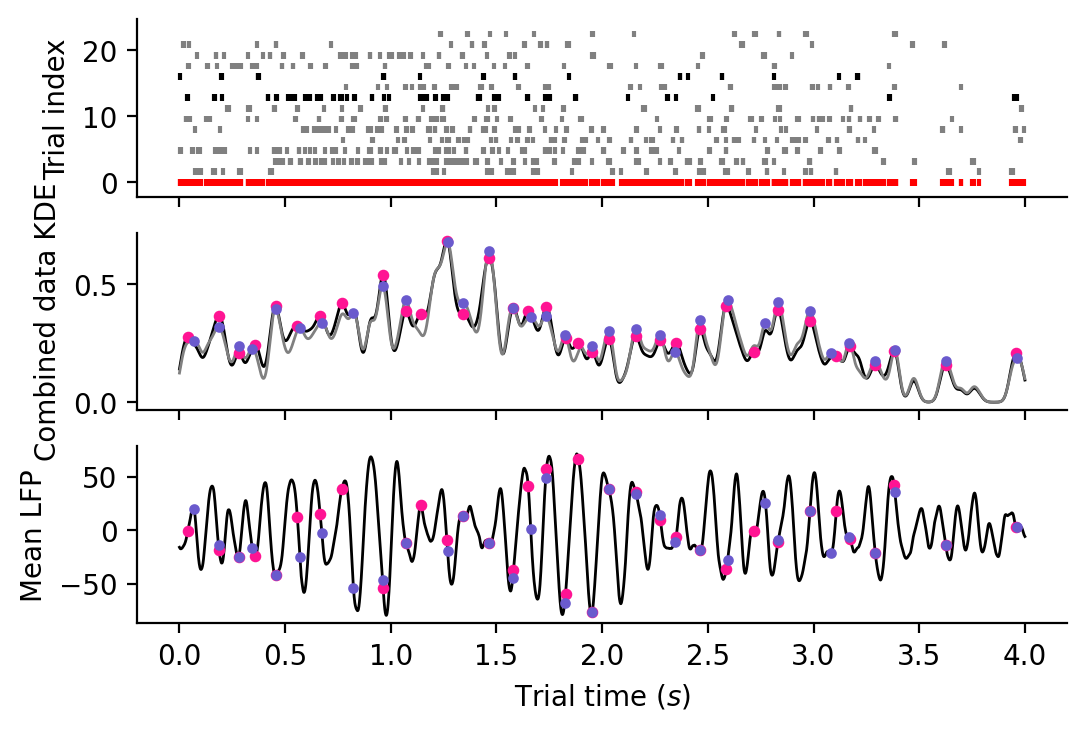

Pyramidal ID: 43


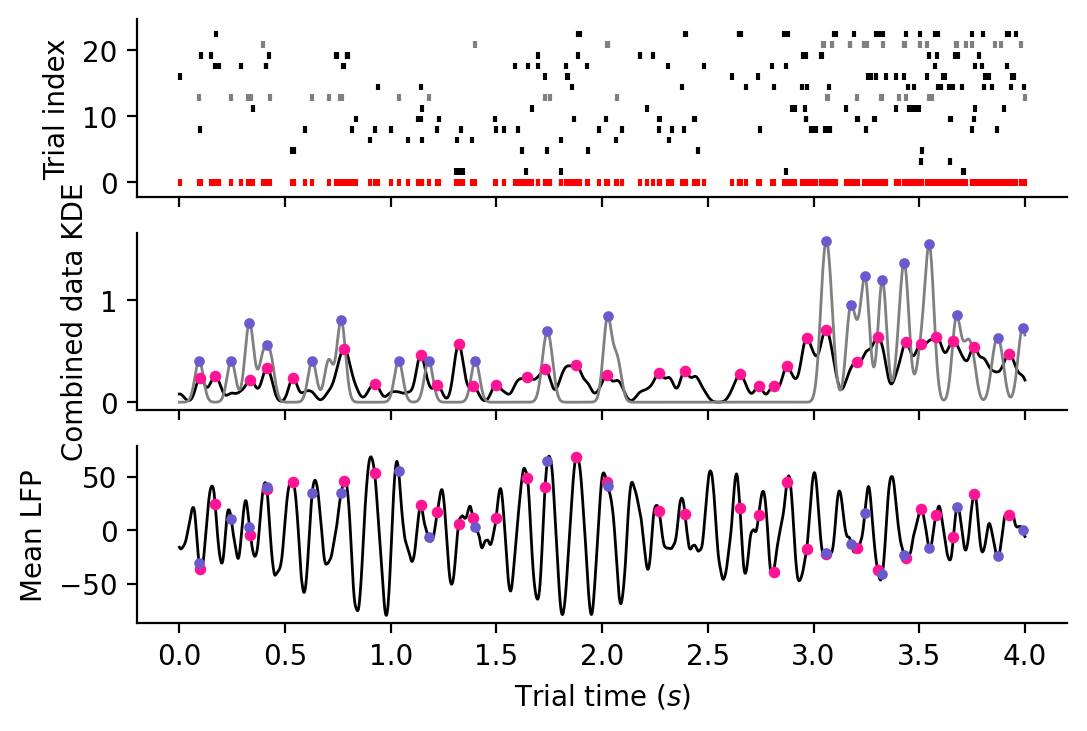

Pyramidal ID: 44


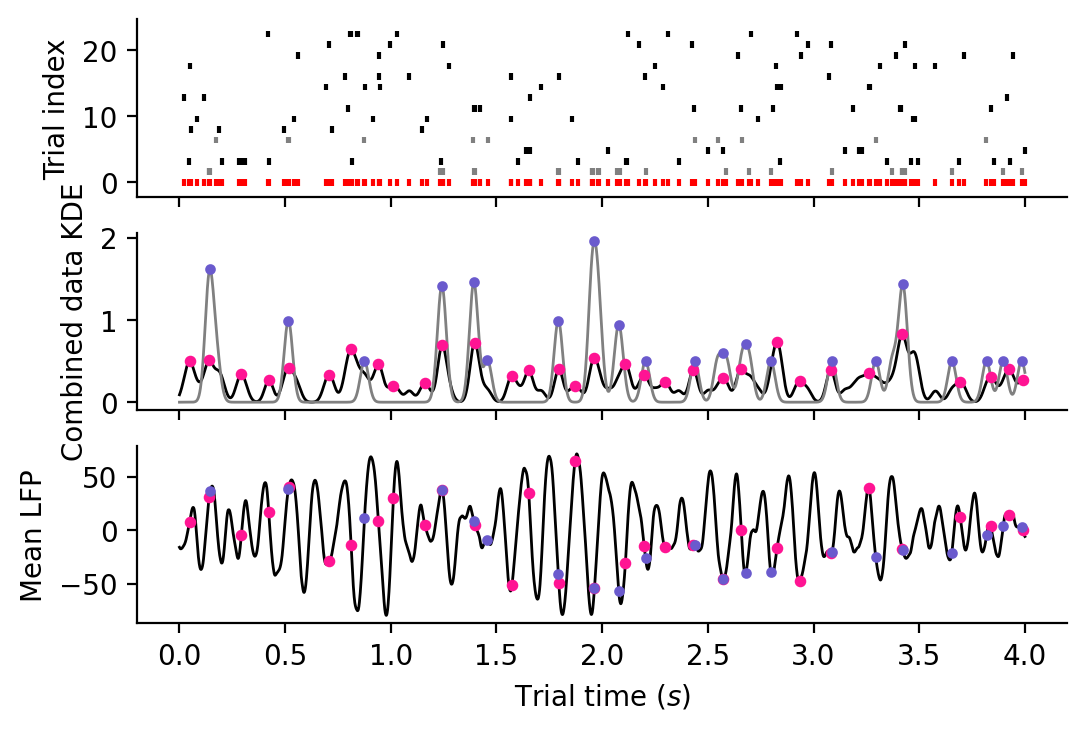

Pyramidal ID: 45


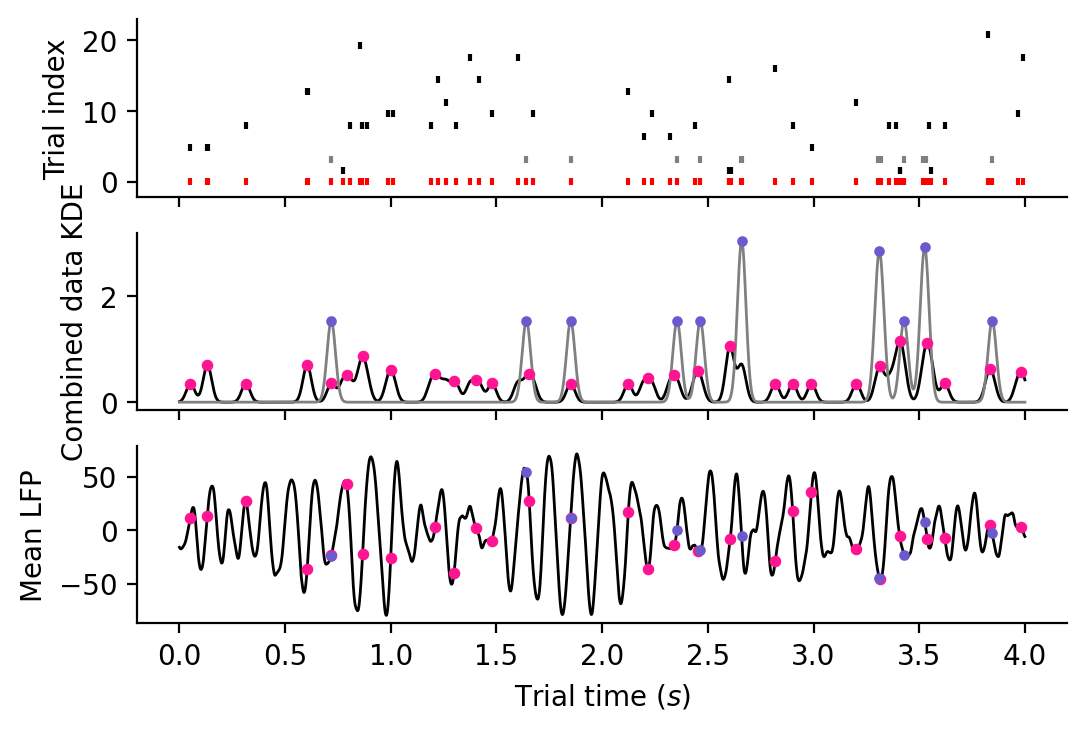

Pyramidal ID: 46


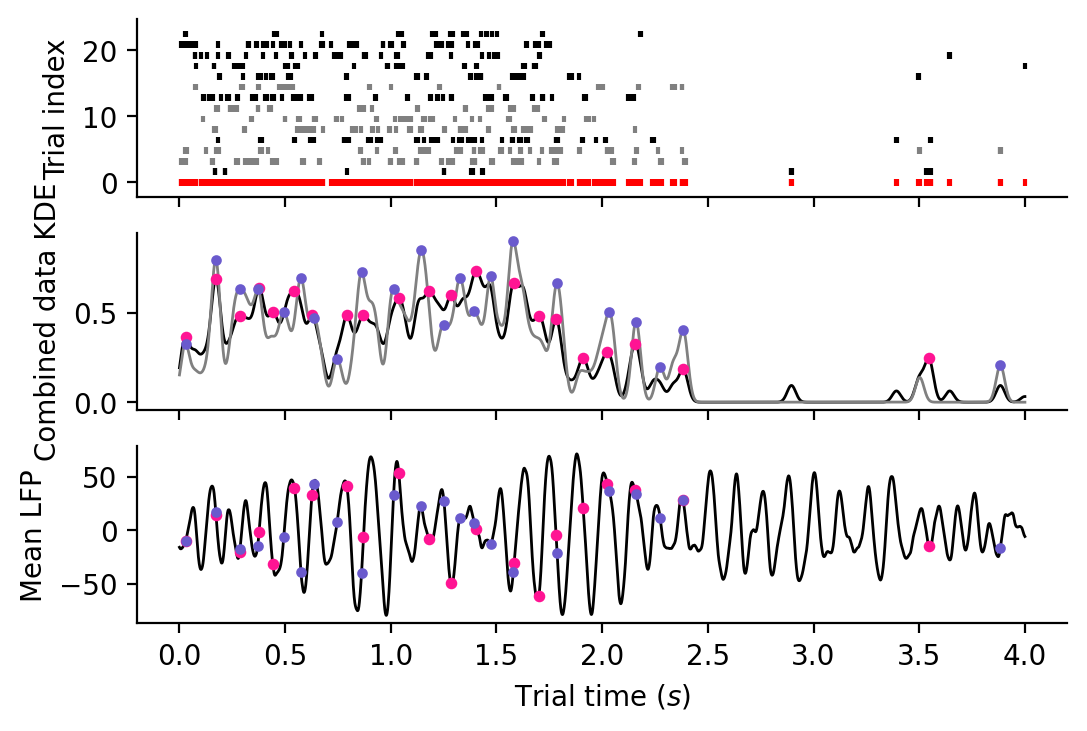

Pyramidal ID: 47


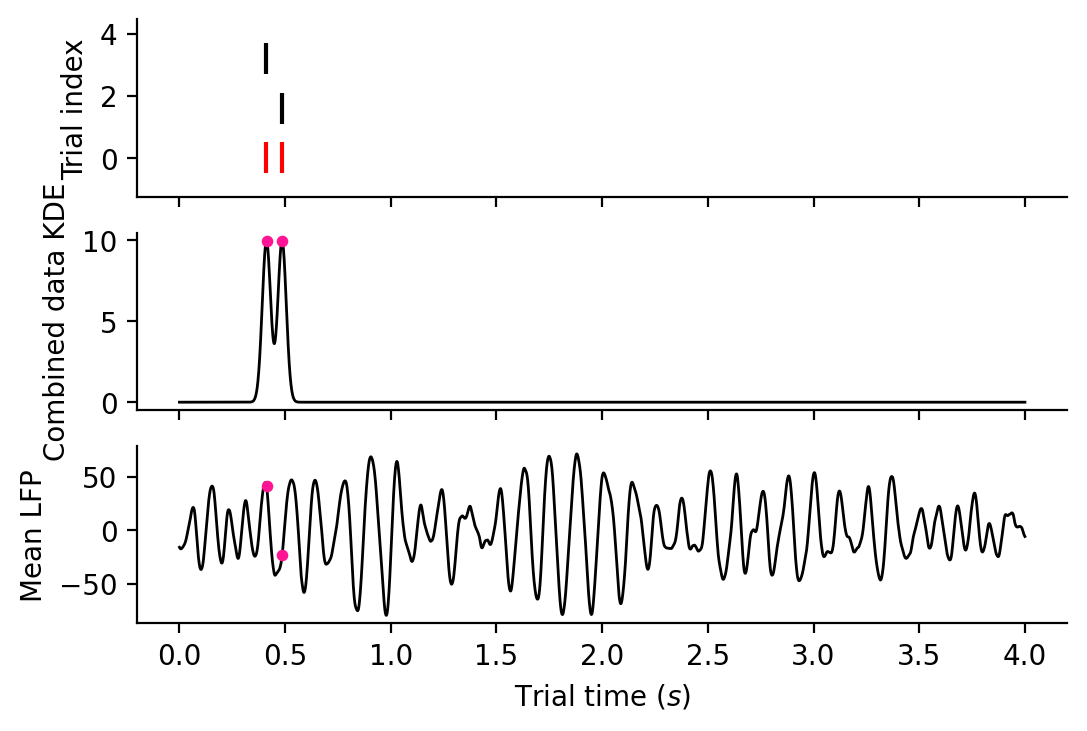

Pyramidal ID: 48


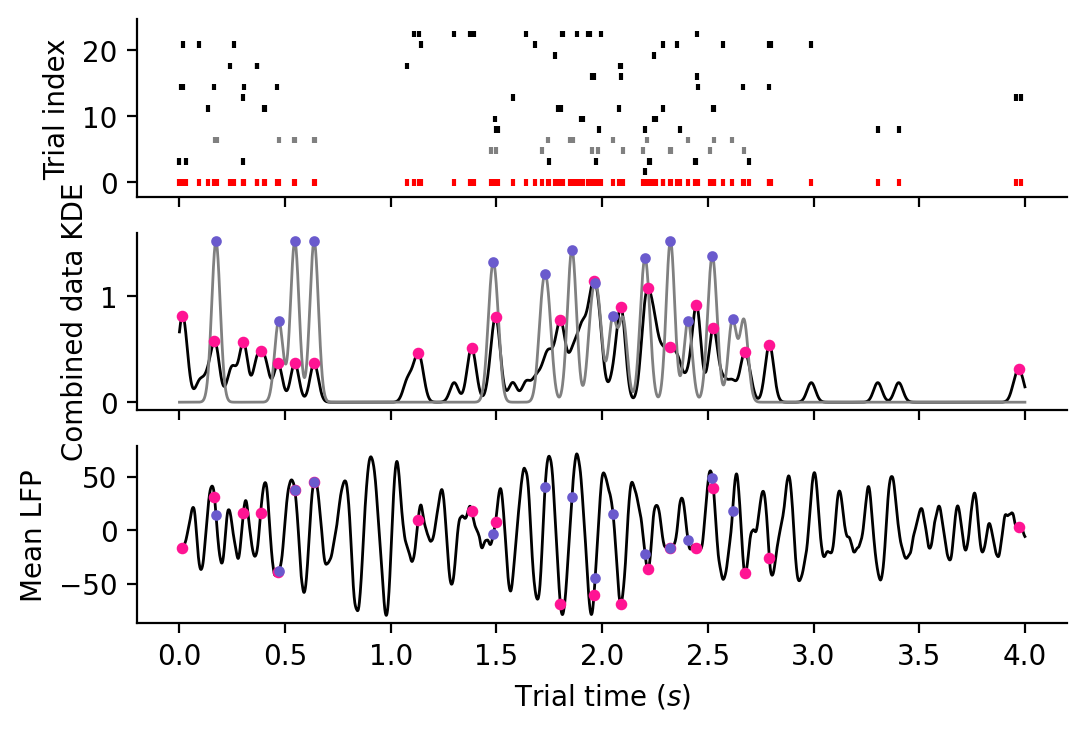

Pyramidal ID: 49


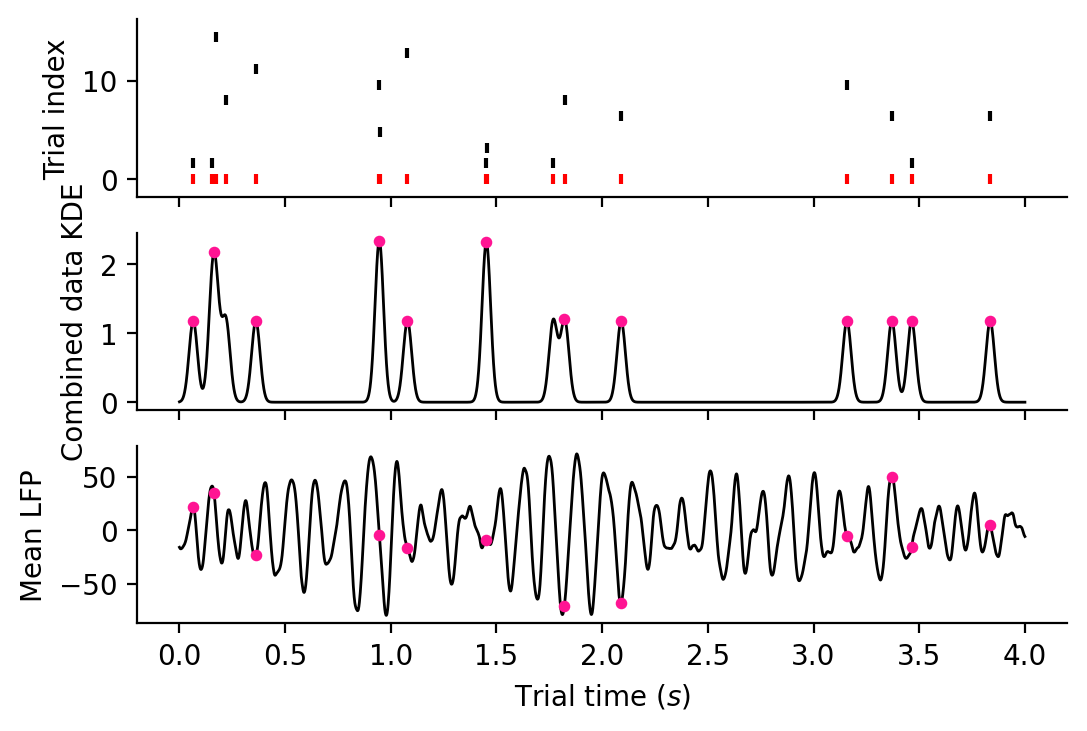

Pyramidal ID: 50


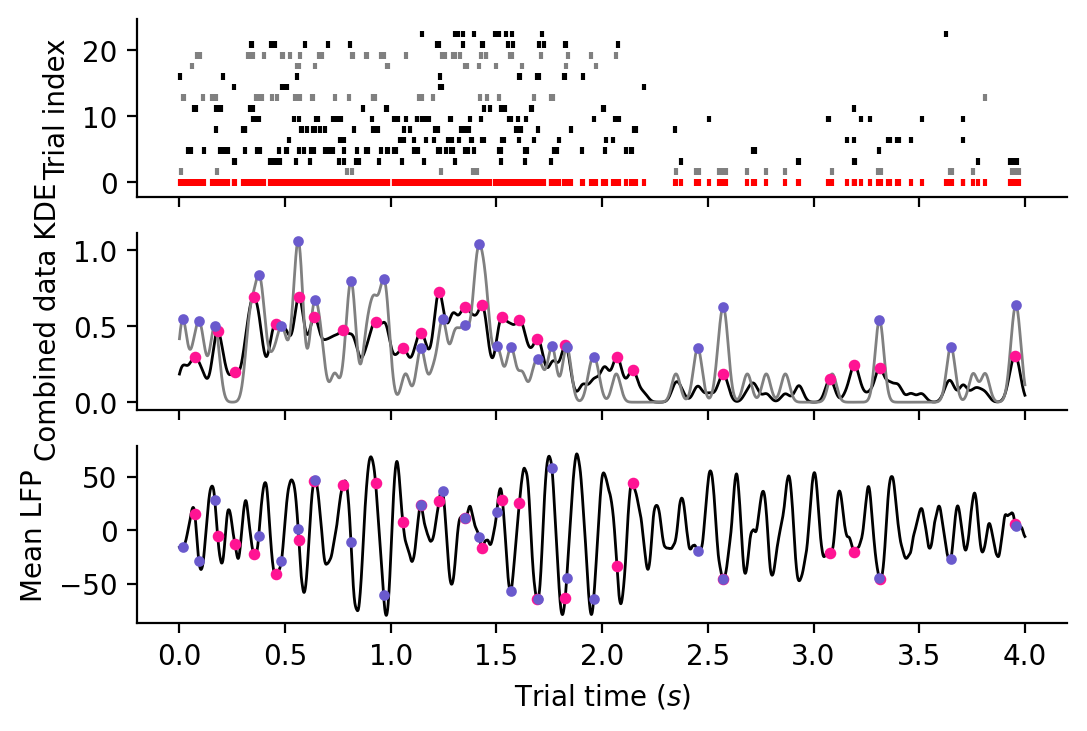

Pyramidal ID: 51


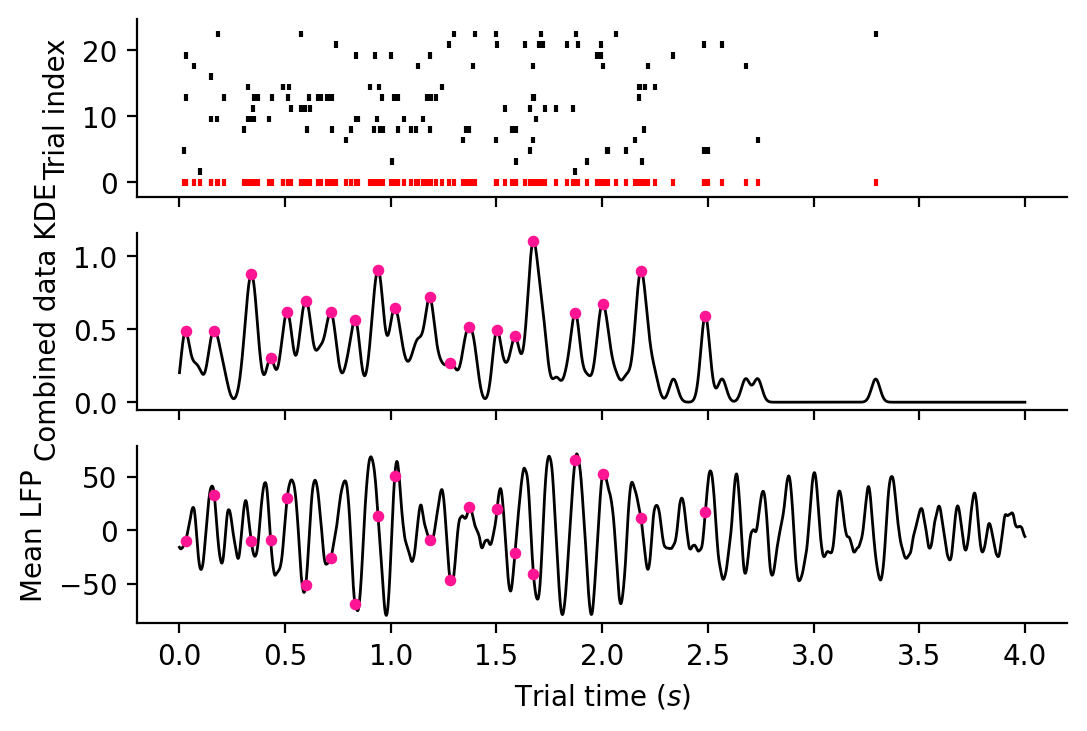

Pyramidal ID: 52


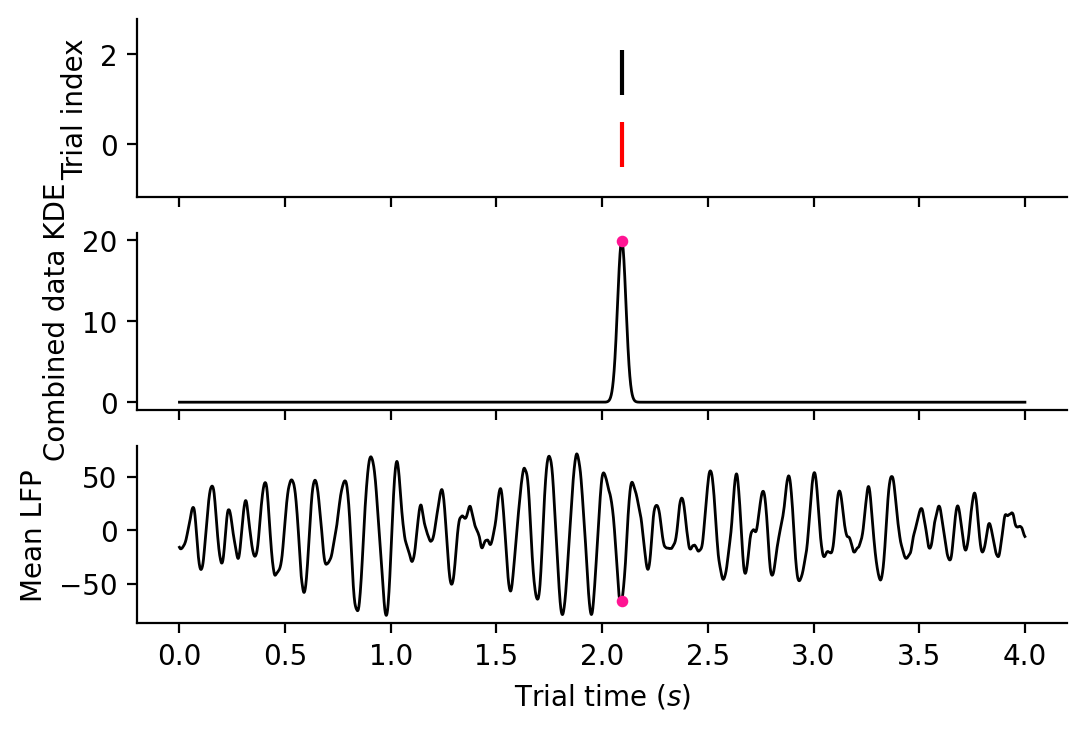

Pyramidal ID: 53


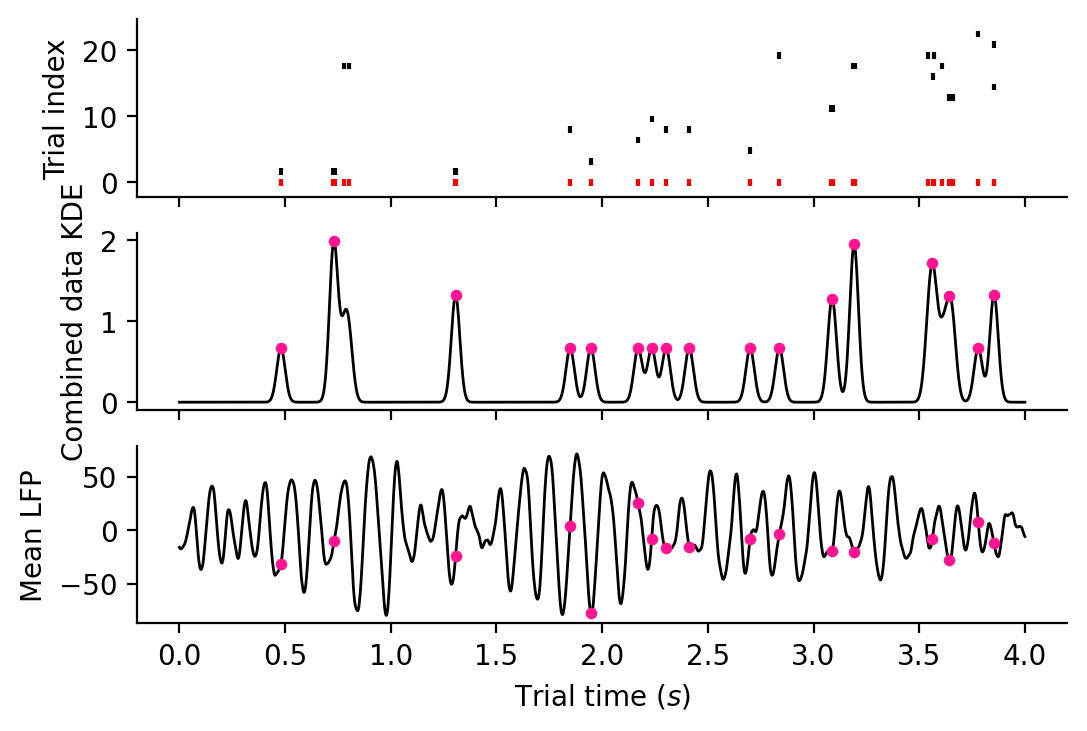

Pyramidal ID: 54


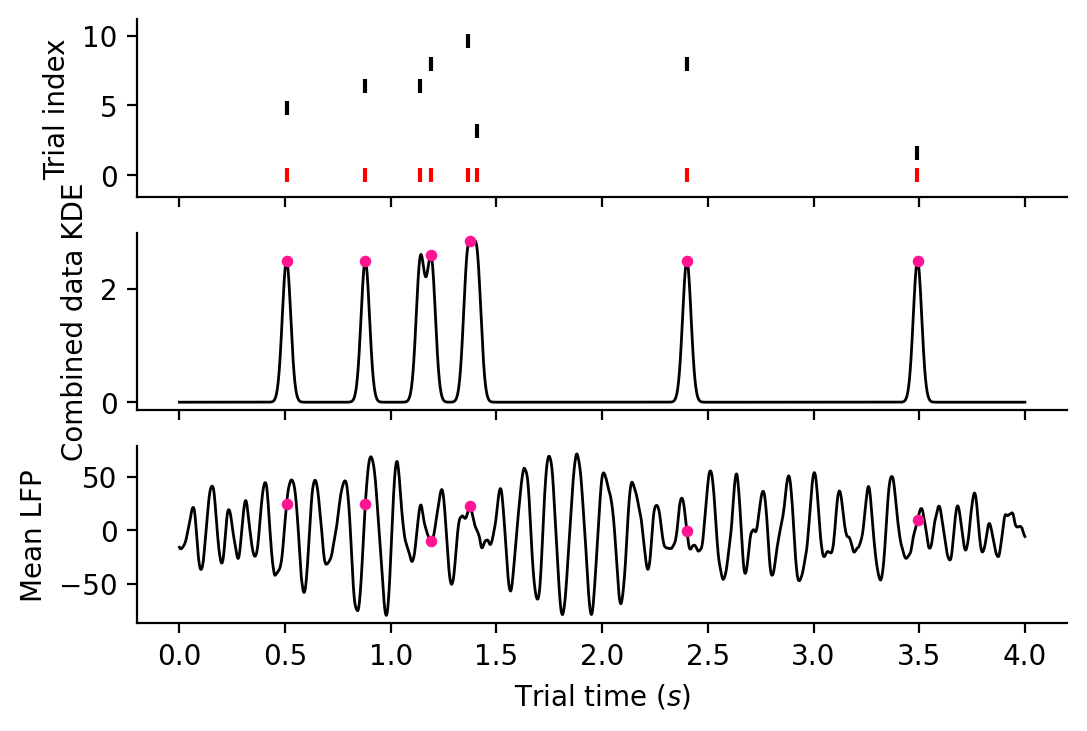

Pyramidal ID: 55


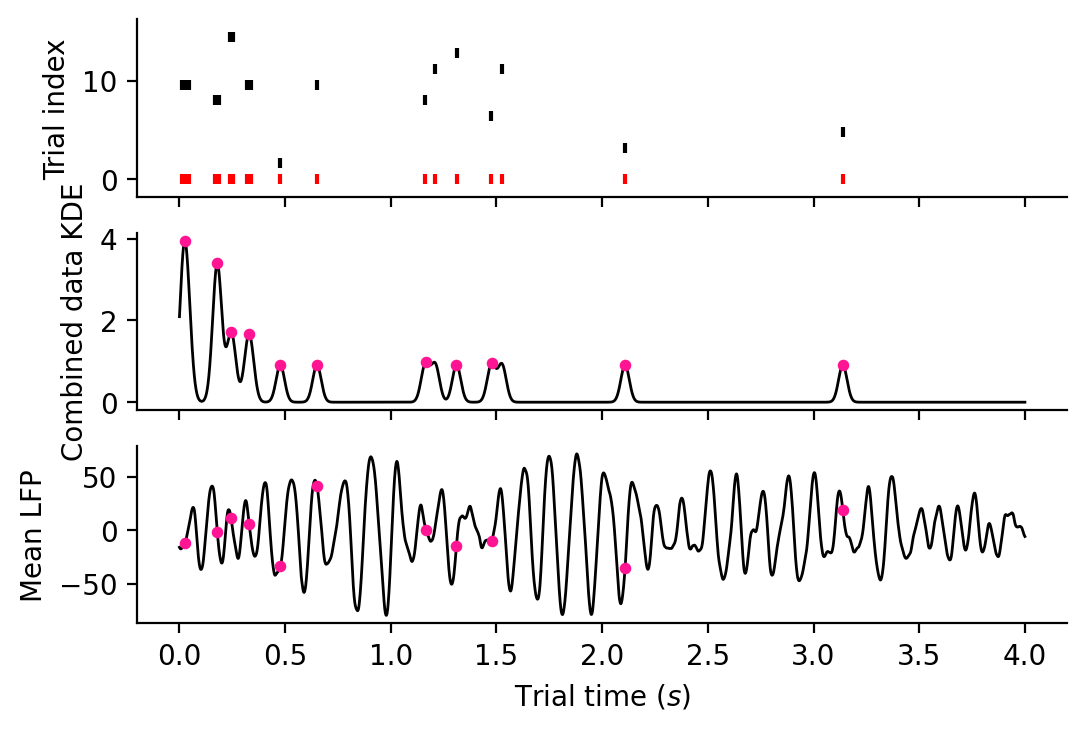

Pyramidal ID: 56


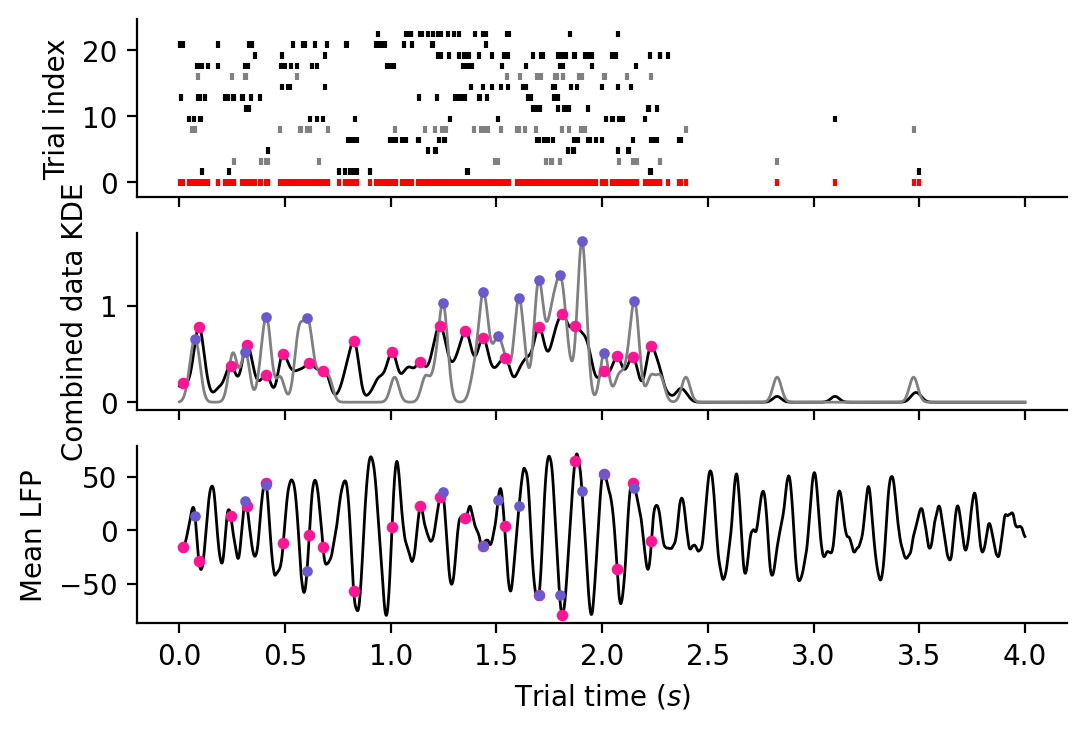

Pyramidal ID: 57


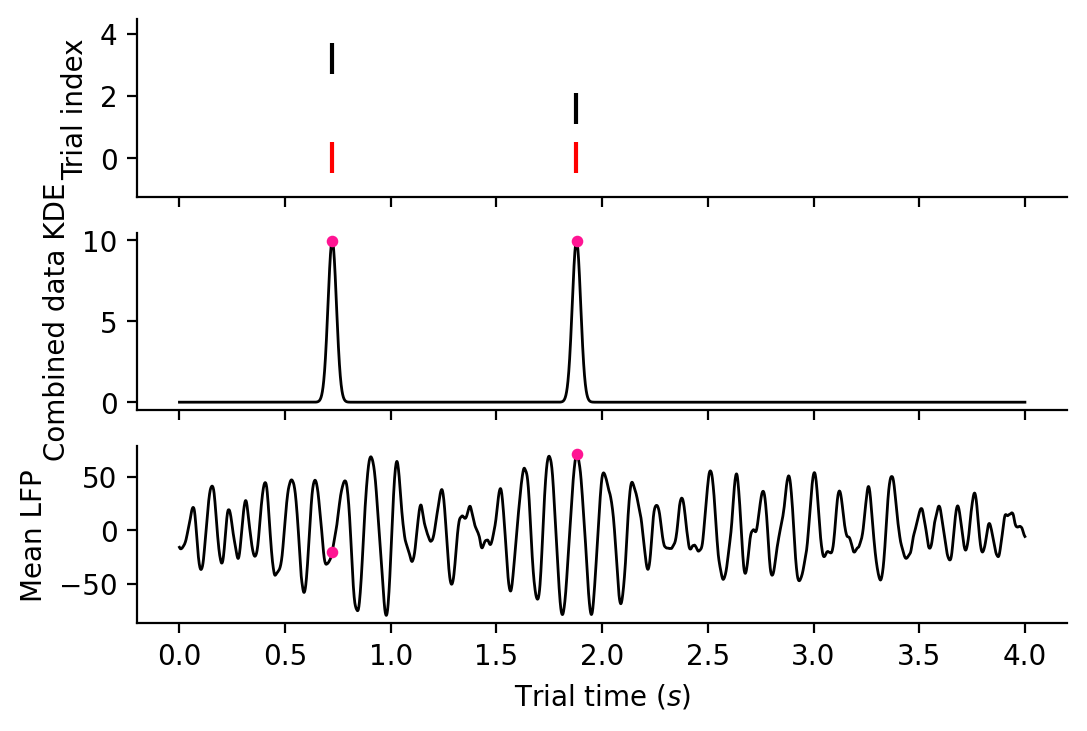

Pyramidal ID: 59


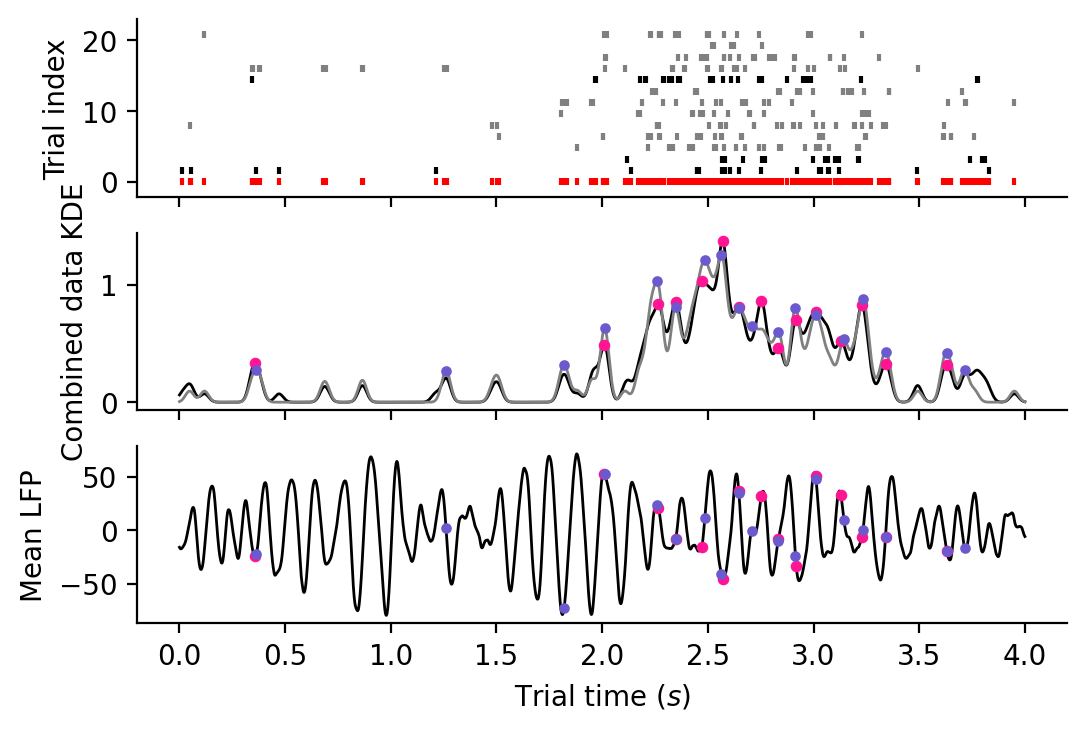

Pyramidal ID: 60


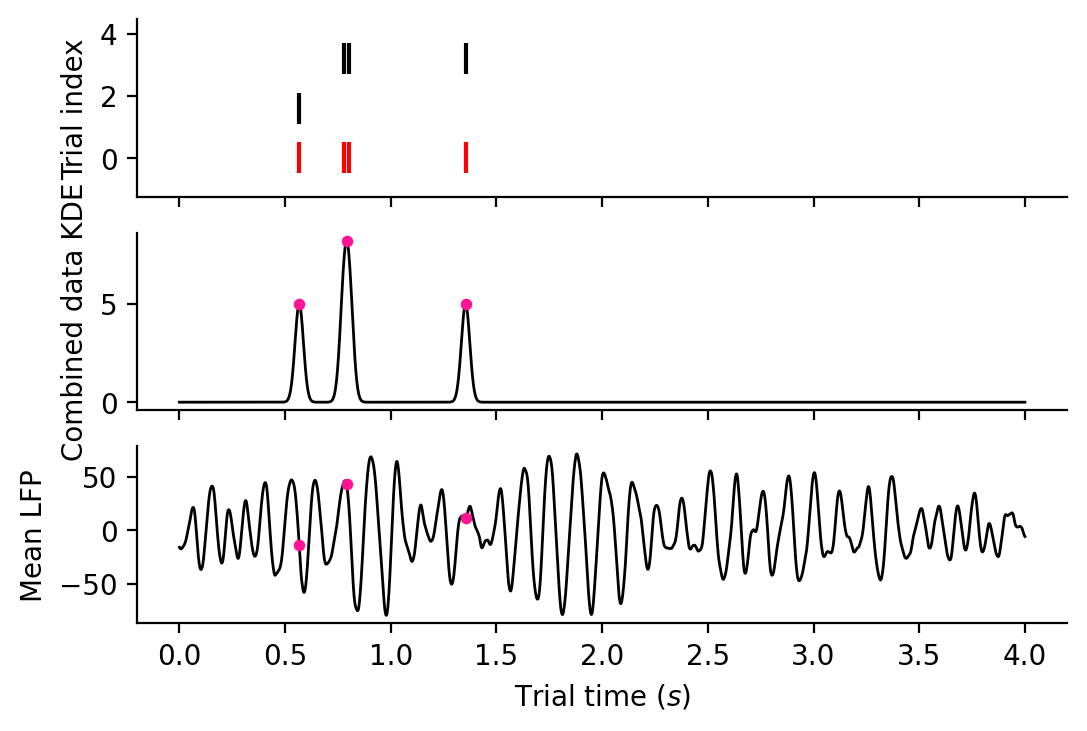

Pyramidal ID: 61


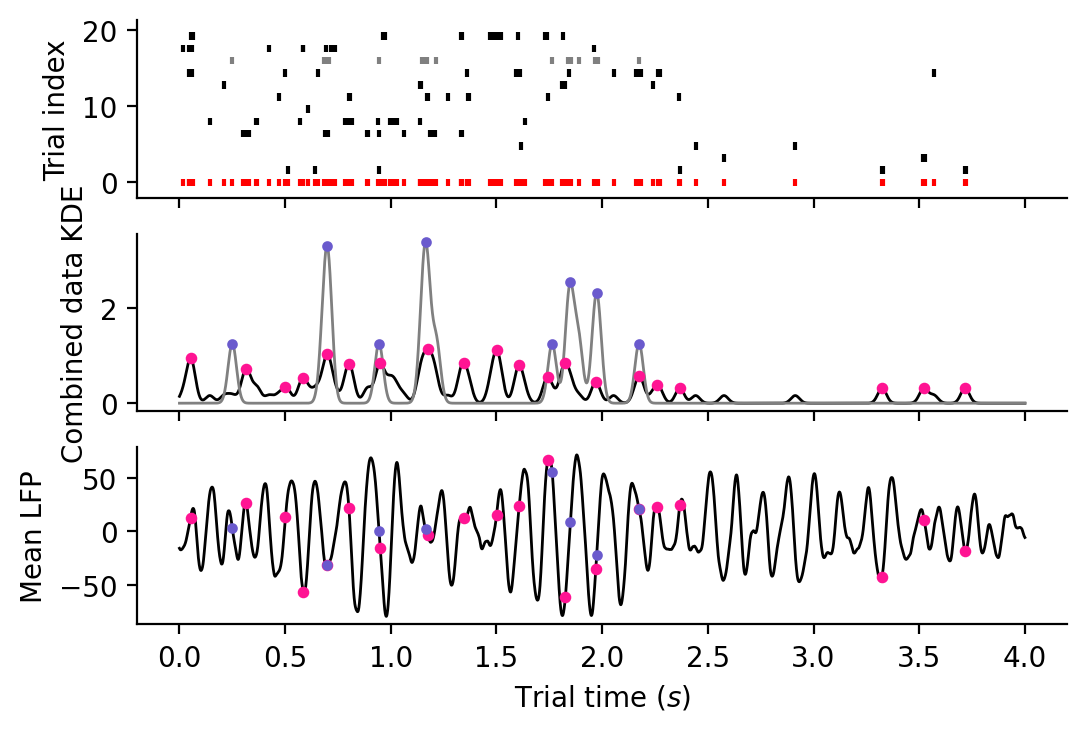

Pyramidal ID: 64


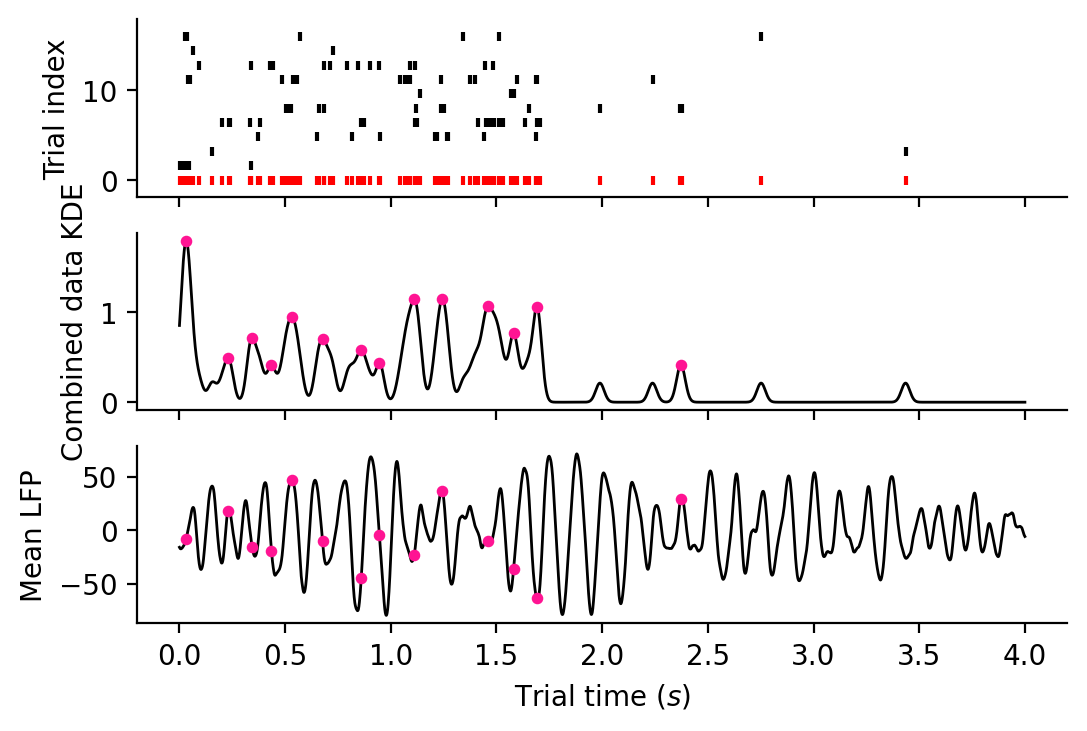

In [86]:
label_data = pd.read_csv('/'.join([os.getcwd(), 'data', 'interim', "mjc57-1212-0110-labels.csv"]))

# Loop over all neuron IDs
for i, neuron in enumerate(neuron_labels):

    col_data = label_data.iloc[:, i].values
    col_data = col_data[~np.isnan(col_data)]
    expert_labels = (col_data*10 % 10).astype(int)

    # Initialize raster data with the trial-combined spike times
    raster_data = [pyr_com_trials[i]]
    for j in np.where(np.array(pyr_sep_neuron_labels) == neuron)[0]:
        raster_data.append(pyr_sep_trials[j]) # ... then append the individual trial spike times one-by-one

    color_list = ['r']
    prec_com_trials = np.array([])
    for j, label in enumerate(expert_labels, start=1):
        if label % 3 == 0:
            color_list.extend(['grey'])
            prec_com_trials = np.concatenate((prec_com_trials, raster_data[j]))
        else:
            color_list.extend(['k'])


    kde_x, kde_y = r_spike_kde([pyr_com_trials[i]], bandwidth, kde_domain_N, kde_domain) # Get the kde for the combined data
    kde_y = kde_y[0] 
    fs = int(trial_N/4) # Lazily ensure sampling frequency is correct
    kde_maxima = find_peaks(kde_y, height=0.2*np.amax(kde_y), distance=0.06*fs)[0] # Get the maxima of the combined data kde (MAGIC NUMBERS)

    if prec_com_trials.shape[0] >= 1:
        prec_kde_x, prec_kde_y = r_spike_kde([prec_com_trials], bandwidth, kde_domain_N, kde_domain)
        prec_kde_y = prec_kde_y[0]
        prec_kde_maxima = find_peaks(prec_kde_y, height=0.2*np.amax(prec_kde_y), distance=0.06*fs)[0]

    print(f'Pyramidal ID: {int(neuron)}')

    # Plot the stuff
    plt.close()
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.patch.set_alpha(0.0)
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0].eventplot(raster_data, colors=color_list, lineoffsets=1.6)
    axes[0].set_ylabel('Trial index')
    axes[1].plot(x_axis, kde_y, color='k', linewidth=1, zorder=0)
    axes[1].scatter(x_axis[kde_maxima], kde_y[kde_maxima], color='deeppink', s=10, zorder=1)

    if prec_com_trials.shape[0] >= 1:
        axes[1].plot(x_axis, prec_kde_y, color='grey', linewidth=1, zorder=0)
        axes[1].scatter(x_axis[prec_kde_maxima], prec_kde_y[prec_kde_maxima], color='slateblue', s=8, zorder=2)
        axes[2].scatter(x_axis[prec_kde_maxima], mean_trial_theta[prec_kde_maxima], color='slateblue', s=8, zorder=2)
        
    axes[1].set_ylabel('Combined data KDE')
    axes[2].plot(x_axis, mean_trial_theta, linewidth=1, color='k', zorder=0)
    axes[2].scatter(x_axis[kde_maxima], mean_trial_theta[kde_maxima], color='deeppink', s=10, zorder=1)
    axes[2].set_ylabel('Mean LFP')
    axes[2].set_xlabel('Trial time ($s$)')

    plt.show()